# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from workspace_utils import active_session
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', delimiter=";")
azdias_customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()
azdias.info
azdias_customers.head()


(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [5]:
azdias_customers.info
azdias_customers.shape
azdias_customers.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,138888.000000,141176.000000,141176.000000,141176.000000
mean,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,2.781176,...,2.537404,2.731510,1.388817,0.539939,1.556607,3.634893,3.622192,2.824850,5.119517,2.898510
std,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,1.147353,...,0.904927,0.840922,0.885038,0.637048,1.185736,0.933660,1.008472,1.012415,2.159184,1.422683
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,2.000000,4.000000,2.000000
50%,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,3.000000,...,3.000000,3.000000,1.000000,0.000000,1.000000,3.000000,4.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.000000


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info

<bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

columns = feat_info['attribute'].values

nan_val = feat_info['missing_or_unknown'].apply(lambda x: pd.to_numeric(x.strip('[]').split(','), errors='ignore'))

nan_az = azdias.copy()


def insert_nan(df, feats):
    columns = feats['attribute'].values
    nan_val = feats['missing_or_unknown'].apply(lambda x: pd.to_numeric(x.strip('[]').split(','), errors='ignore'))
    
    for index, val in enumerate(nan_val):
        column = columns[index]
        df.replace({column: val}, np.nan, inplace=True )
    return df


In [9]:
nan_az = insert_nan(nan_az, feat_info)

In [10]:
%config InlineBackend.figure_format = 'retina'
# nan_az.replace({'AGER_TYP': ['-1',0]}, np.nan, inplace=True)
# nan_az.iloc[:5,:5].hist(figsize=(40,40))
# plt.tight_layout()
nan_az.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

nans = nan_az.isnull().sum()

prop_nan = nans/azdias.shape[0]

Text(0.5,0,'Missing Data')

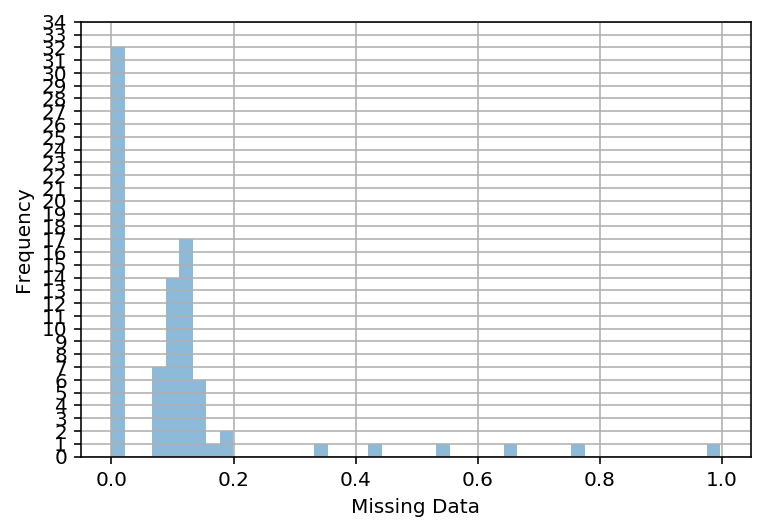

In [12]:
ax = prop_nan.plot.hist(bins=45, alpha=0.5, grid=True)
ax.set_yticks(list(range(0,35,1)))

plt.xlabel("Missing Data")


In [13]:
# Investigate patterns in the amount of missing data in each column.

# print(prop_nan)

to_remove = prop_nan.where(lambda x: x > 0.2).dropna()
print(to_remove)
to_remove_cols = list(to_remove.index.values)
print(to_remove_cols)

AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
ALTER_HH        0.348137
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

nan_az = nan_az.drop(to_remove_cols, axis=1)
nan_az.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


Most of the columns had data that was at least 80% complete.  However, there were nine columns that were missing between 34.8% and 99.8% of the data which I decided to remove.  These columns and the amount of data each one was missing as a proportion of the total are:


Feature Column|  Proportion Missing
-------------:|---------------------:
AGER_TYP      | 0.769554
GEBURTSJAHR   |  0.440203
TITEL_KZ      |  0.997576
ALTER_HH      |  0.348137
KK_KUNDENTYP  |  0.655967
KBA05_BAUMAX  |  0.534687

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0,0.5,'Count')

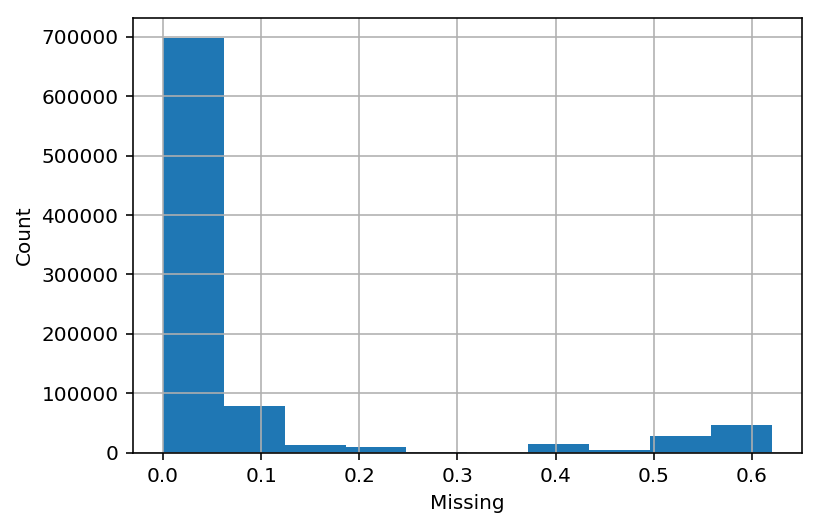

In [15]:
# How much data is missing in each row of the dataset?

nans_per_row = nan_az.isnull().sum(axis=1)
prop_nans_per_row = nans_per_row/nan_az.shape[1]
prop_nans_per_row.hist()
plt.xlabel('Missing')
plt.ylabel('Count')


In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_to_remove = prop_nans_per_row.where(lambda x: x > 0.3).dropna()
to_remove_rows = list(rows_to_remove.index.values)
print('Number of rows to drop:', len(to_remove_rows))
print('About {} percent of the rows are missing greater than 30% of the data'.format(len(to_remove_rows)/nan_az.shape[0]*100))

azdias_final = nan_az.drop(to_remove_rows)

print('nan_az shape: ',nan_az.shape)
complete_cols = list(nan_az.count().where(lambda x: x == 891221).dropna().index.values)
print(complete_cols)
print('number of columns that are not missing entries', len(complete_cols))


Number of rows to drop: 93384
About 10.478209108627377 percent of the rows are missing greater than 30% of the data
nan_az shape:  (891221, 79)
['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
number of columns that are not missing entries 24


In [17]:
azdias_dropped = nan_az.loc[to_remove_rows]
azdias_dropped.shape

(93384, 79)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


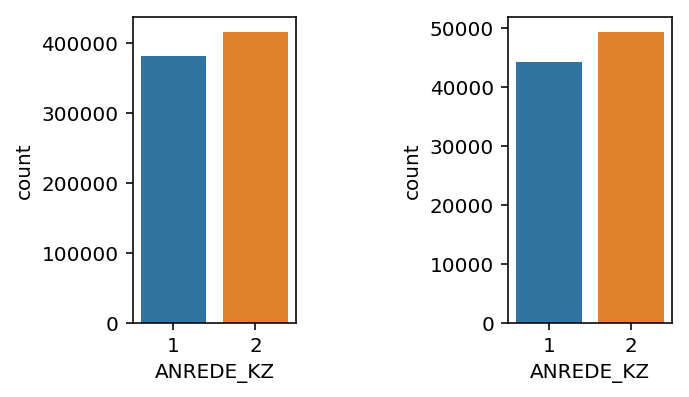

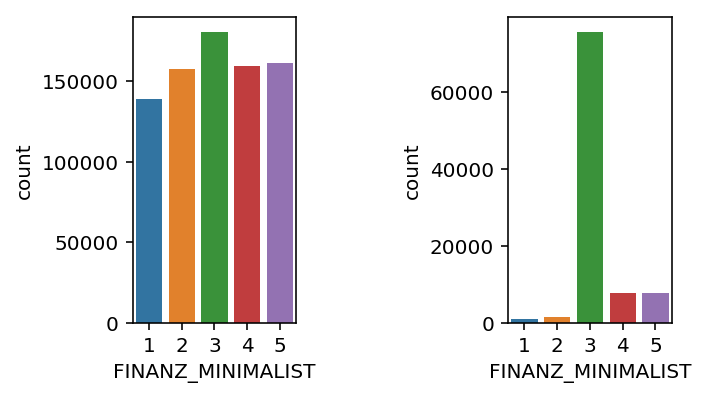

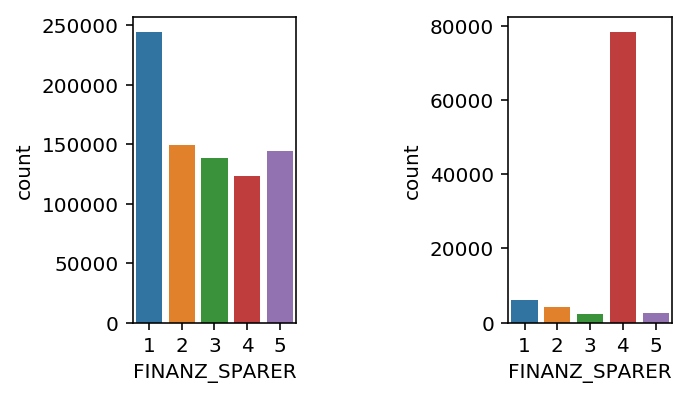

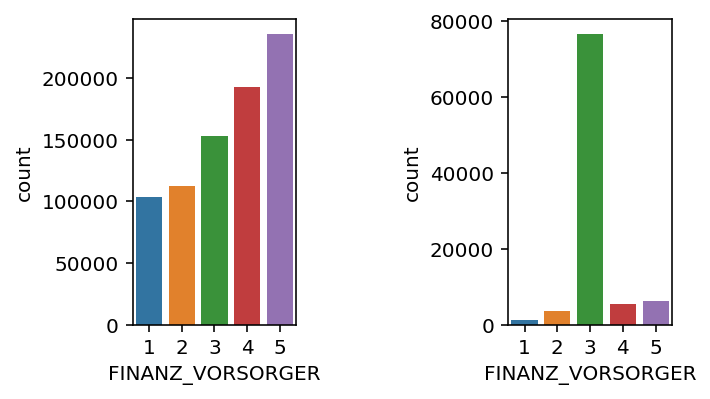

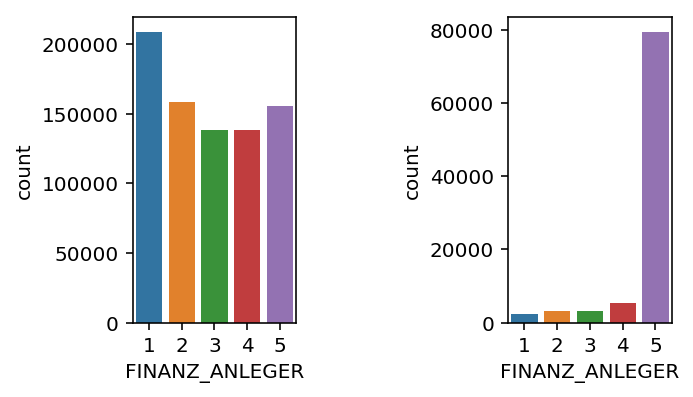

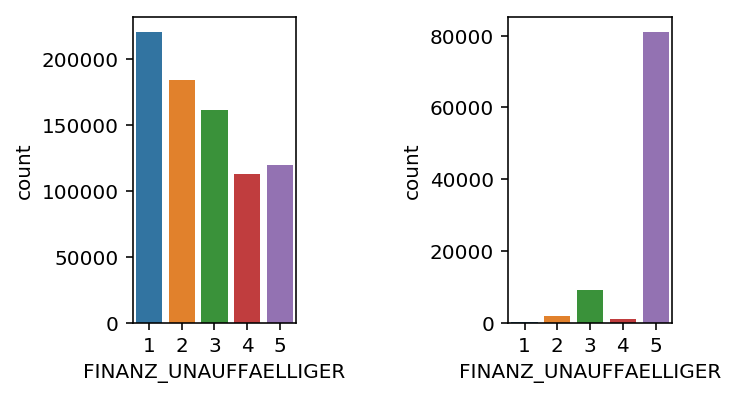

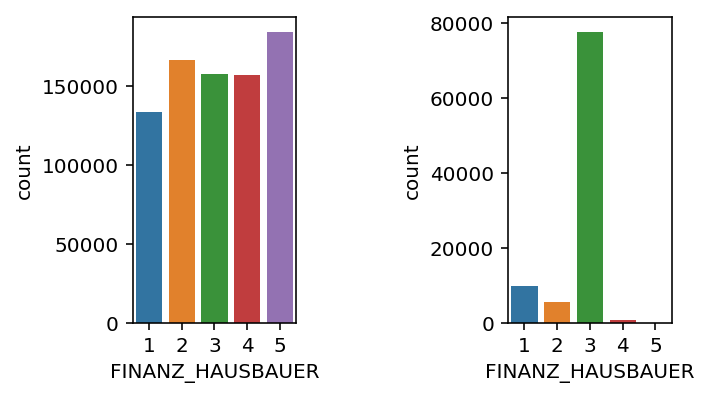

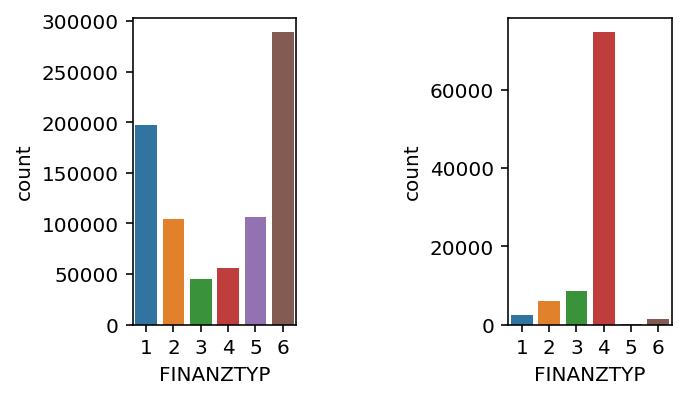

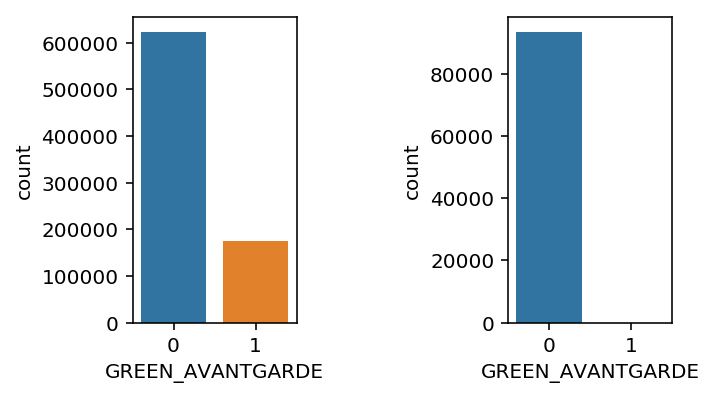

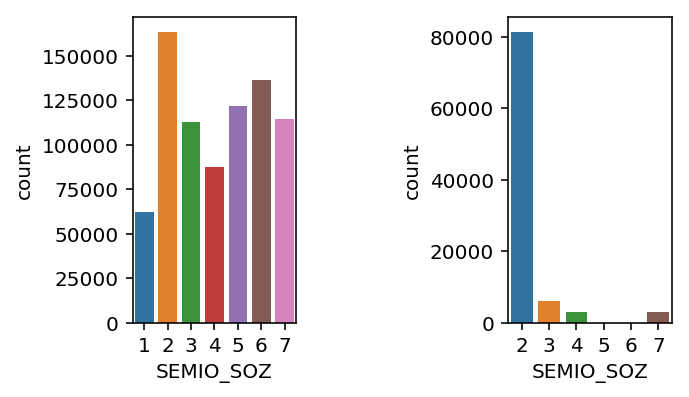

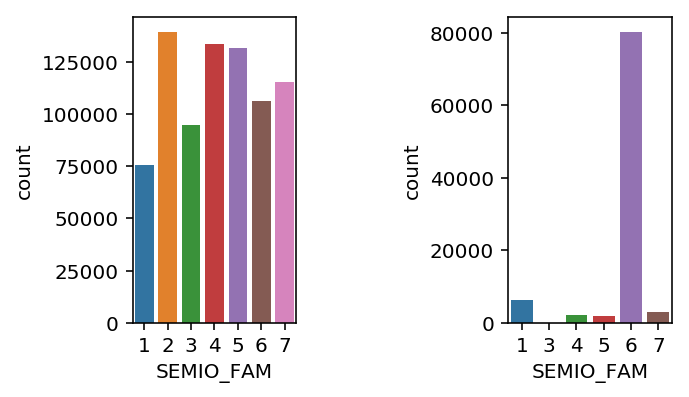

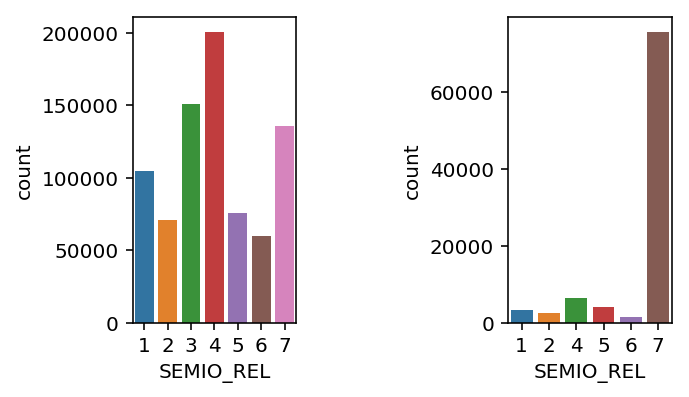

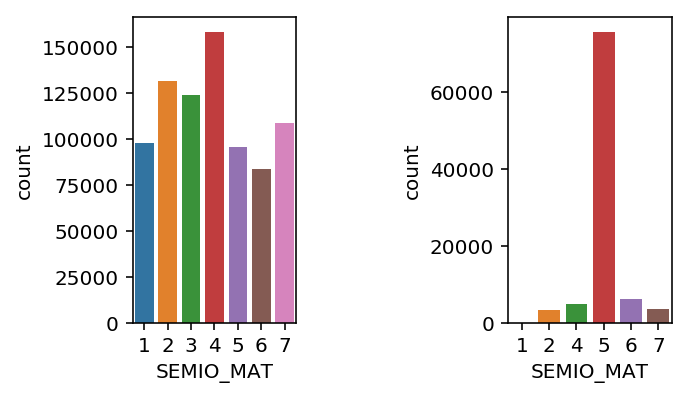

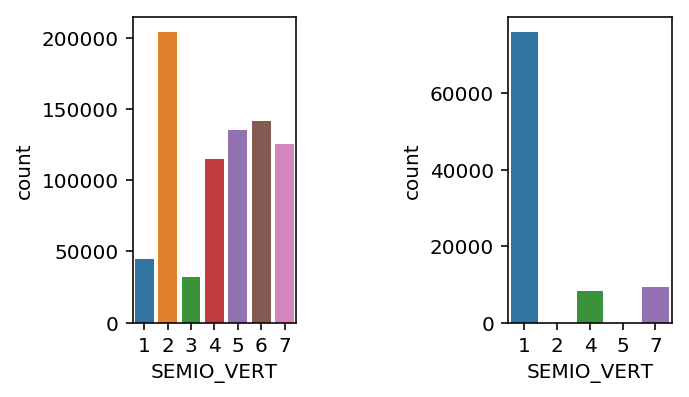

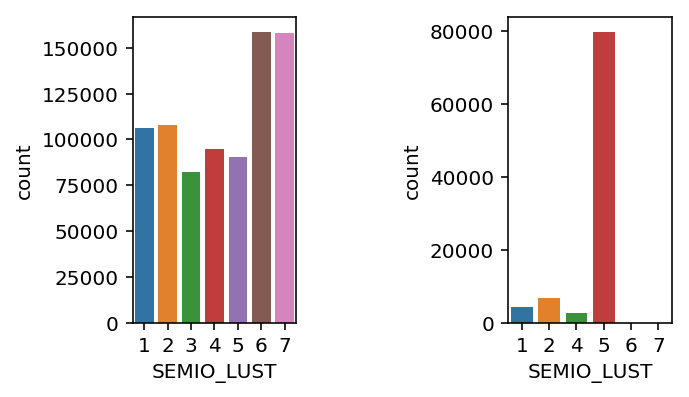

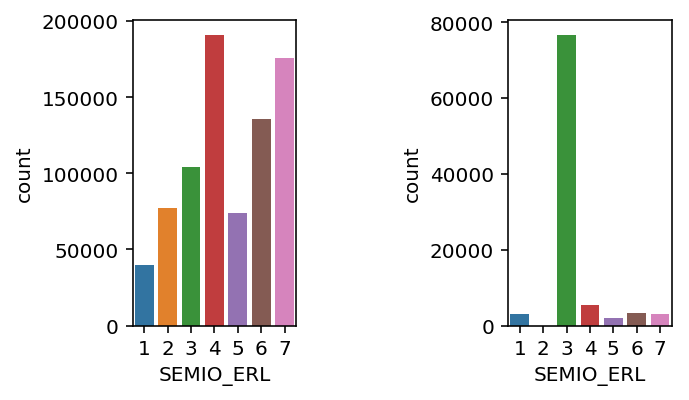

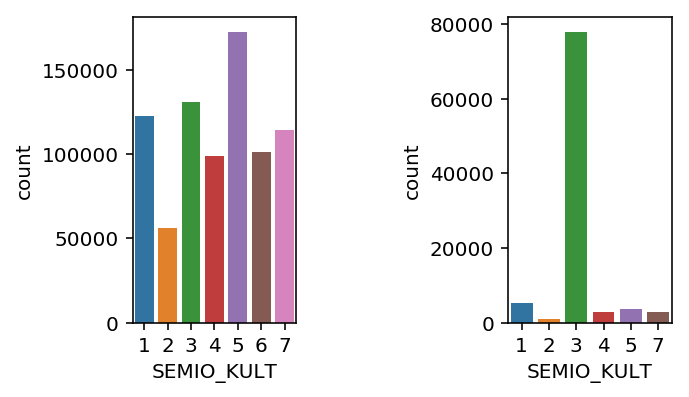

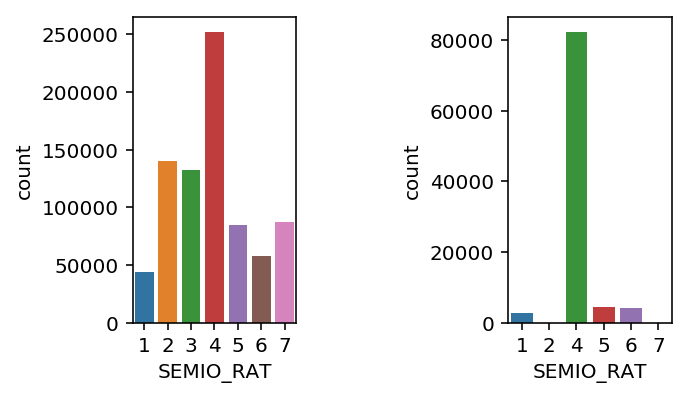

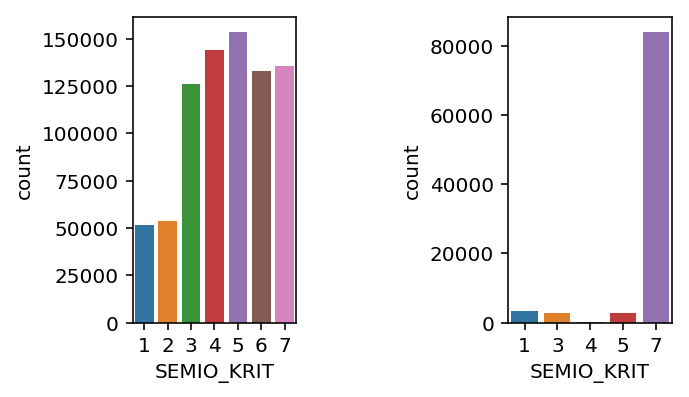

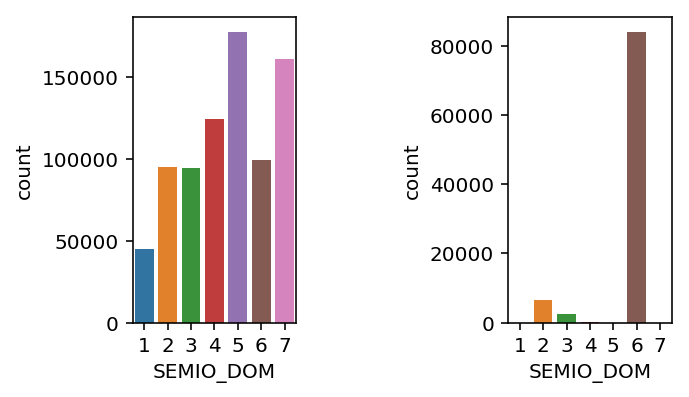

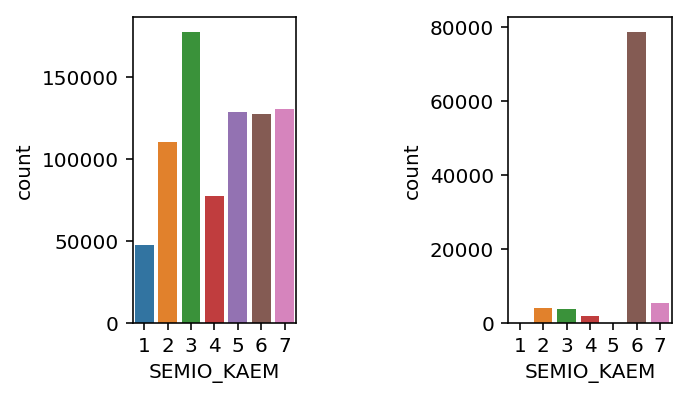

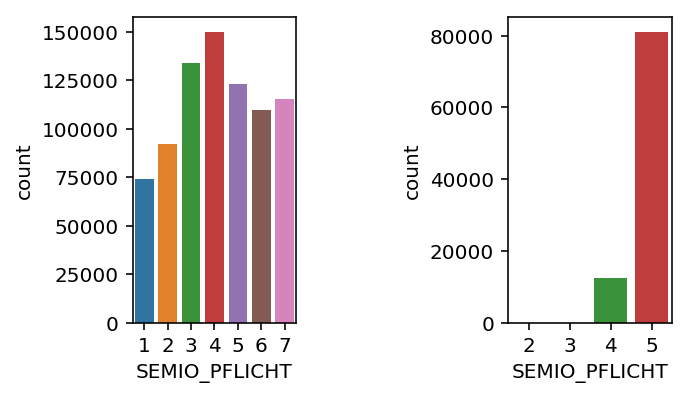

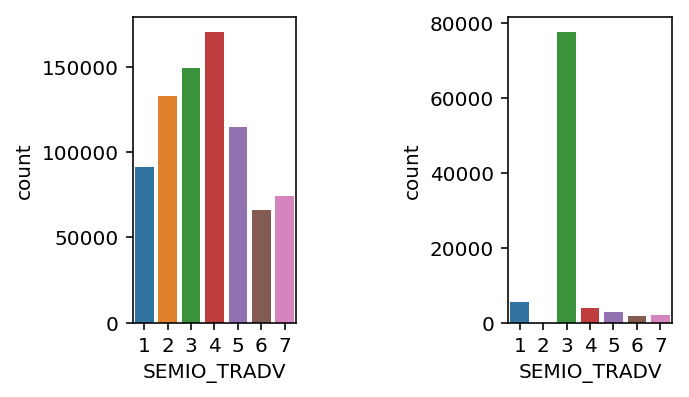

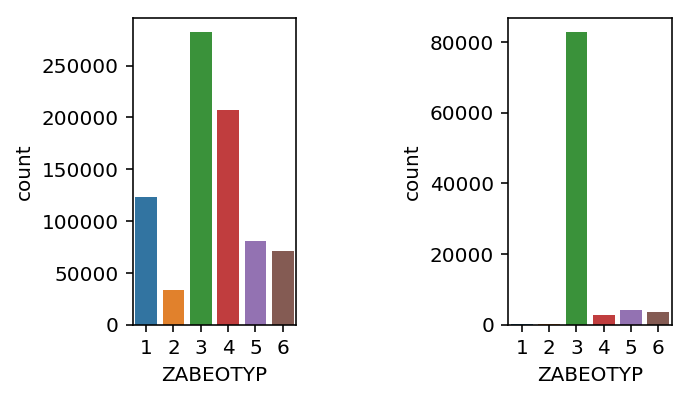

In [18]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_dist(df1, df2, columnsAr):

    for column in columnsAr:
        fig, ax =plt.subplots(1,2)
        sns.countplot(df1[column], ax=ax[0])
        sns.countplot(df2[column], ax=ax[1])
        plt.tight_layout(pad=5)
    fig.show()
    
    
compare_dist(azdias_final, azdias_dropped, complete_cols)


### Discussion 1.1.3: Assess Missing Data in Each Row

About 10% of the data rows were missing data in more than 30% of the columns.  In order to examine this a little more the data set was split into two dataframes, one consisting of entries that had information for more than 70% of the columns and one consisting of the entries that had less than 70% complete.  Then I compared the values for these entries for the 24 columns that were not missing any values by constructing histograms for both dataframes.  I found that the 10% of entries that were less than 70% complete were very different from the entries that were at least 70% complete in every column I looked at except gender (ANREDE_KZ).  I will continue forward with the rows that are mostly complete for now but will revisit the incomplete rows further in my analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?

num_count = feat_info['type'].value_counts()
print(num_count)

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Update feature info dataframe to reflect the current dataset with columns removed
updated_feat_info = feat_info.copy()

for col in to_remove_cols:
    updated_feat_info = updated_feat_info.where(lambda df: df.attribute != col)

In [21]:
updated_feat_info.dropna()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64ba0da8d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f64ba3ce2e8>]], dtype=object)

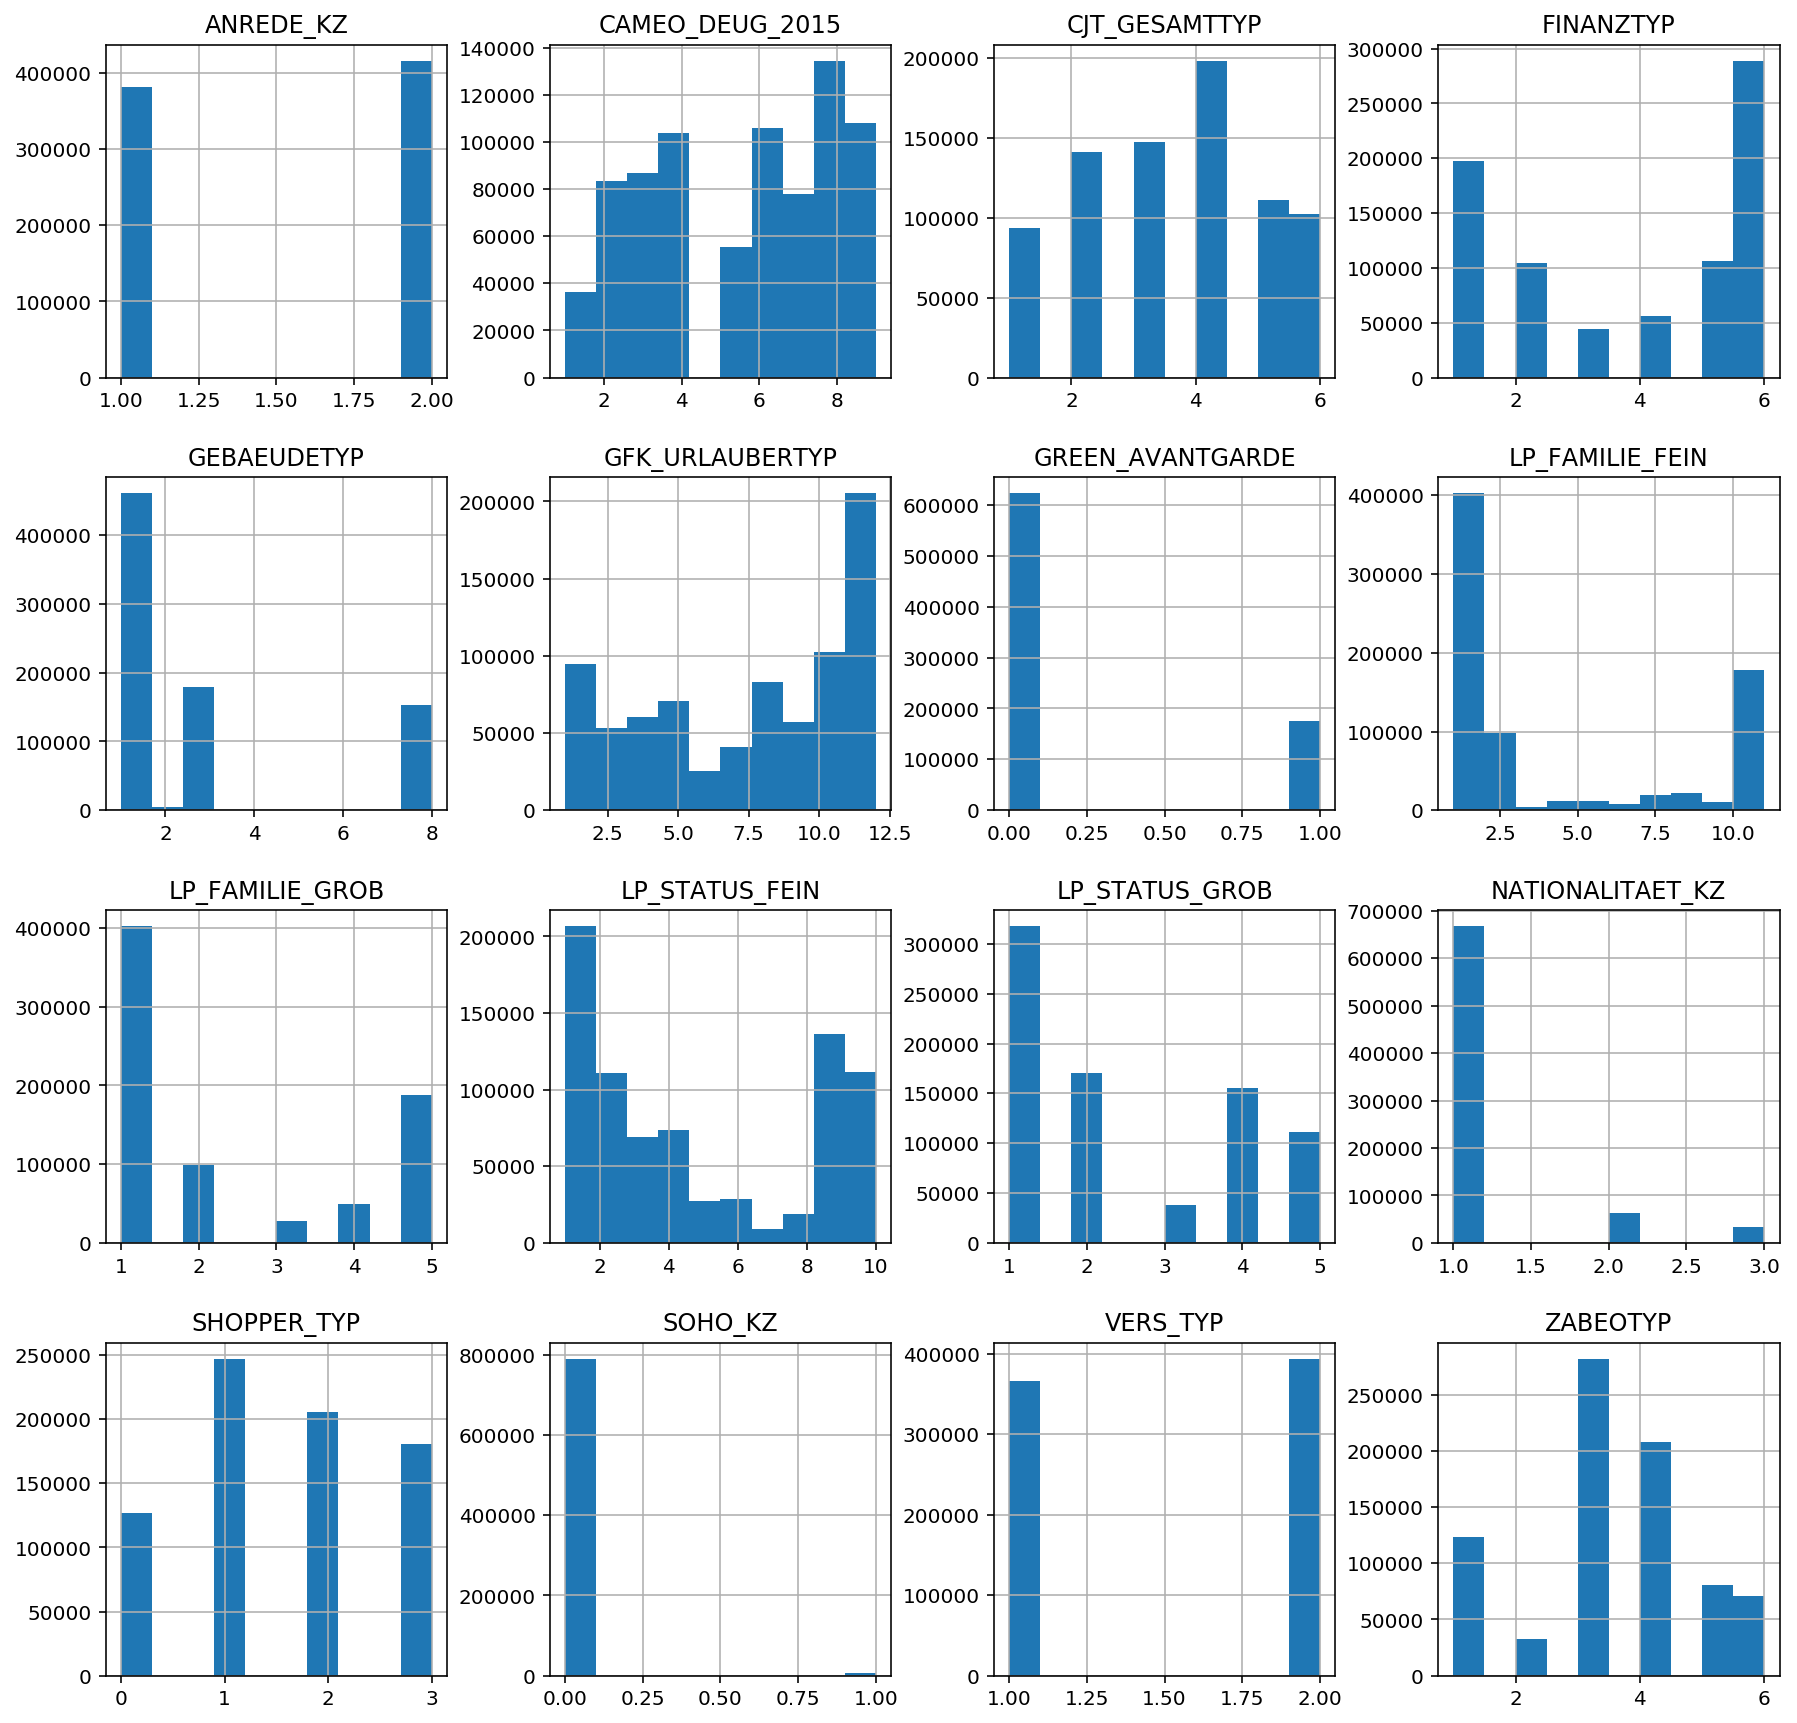

In [22]:

# Get a list of categorical columns
categorical = updated_feat_info.where(lambda df: df['type']=='categorical').dropna()
categorical_cols = list(categorical.attribute.values)
categorical_cols = list(filter(lambda x: x not in to_remove_cols, categorical_cols))

# Re-encode Cameo Deug
azdias_final['CAMEO_DEUG_2015'] = pd.to_numeric(azdias_final['CAMEO_DEUG_2015'], errors='ignore')
azdias_final[categorical_cols].hist(figsize=(15,15))

In [23]:
len(categorical_cols)
print(categorical_cols)

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [25]:
# function to one-hot-encode a list of categorical columns
def one_hot_multi_cats(dataframe, cols):
    for col in cols:
        if (col in dataframe.columns.values) and (dataframe[col].value_counts().shape[0] > 2):
            dataframe = pd.concat([dataframe, pd.get_dummies(dataframe[col], prefix=col)], axis=1)
            dataframe.drop([col], axis=1, inplace=True)
    return dataframe

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode east/west
azdias_final.replace({'OST_WEST_KZ': {'O':0, 'W':1}}, inplace=True)

# Re-encode Cameo Deu
azdias_final = one_hot_multi_cats(azdias_final, ['CAMEO_DEU_2015'])
# azdias_final.replace({'CAMEO_DEU_2015': cameo_deu_dict}, inplace=True)
# azdias_final['CAMEO_DEU_2015'].head()
# azdias_final = pd.concat([azdias_final, pd.get_dummies(azdias_final['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015',)],axis=1)
# azdias_final.drop(['CAMEO_DEU_2015'],axis=1, inplace=True)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f64ba5dbc88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f64ba209b00>]], dtype=object)

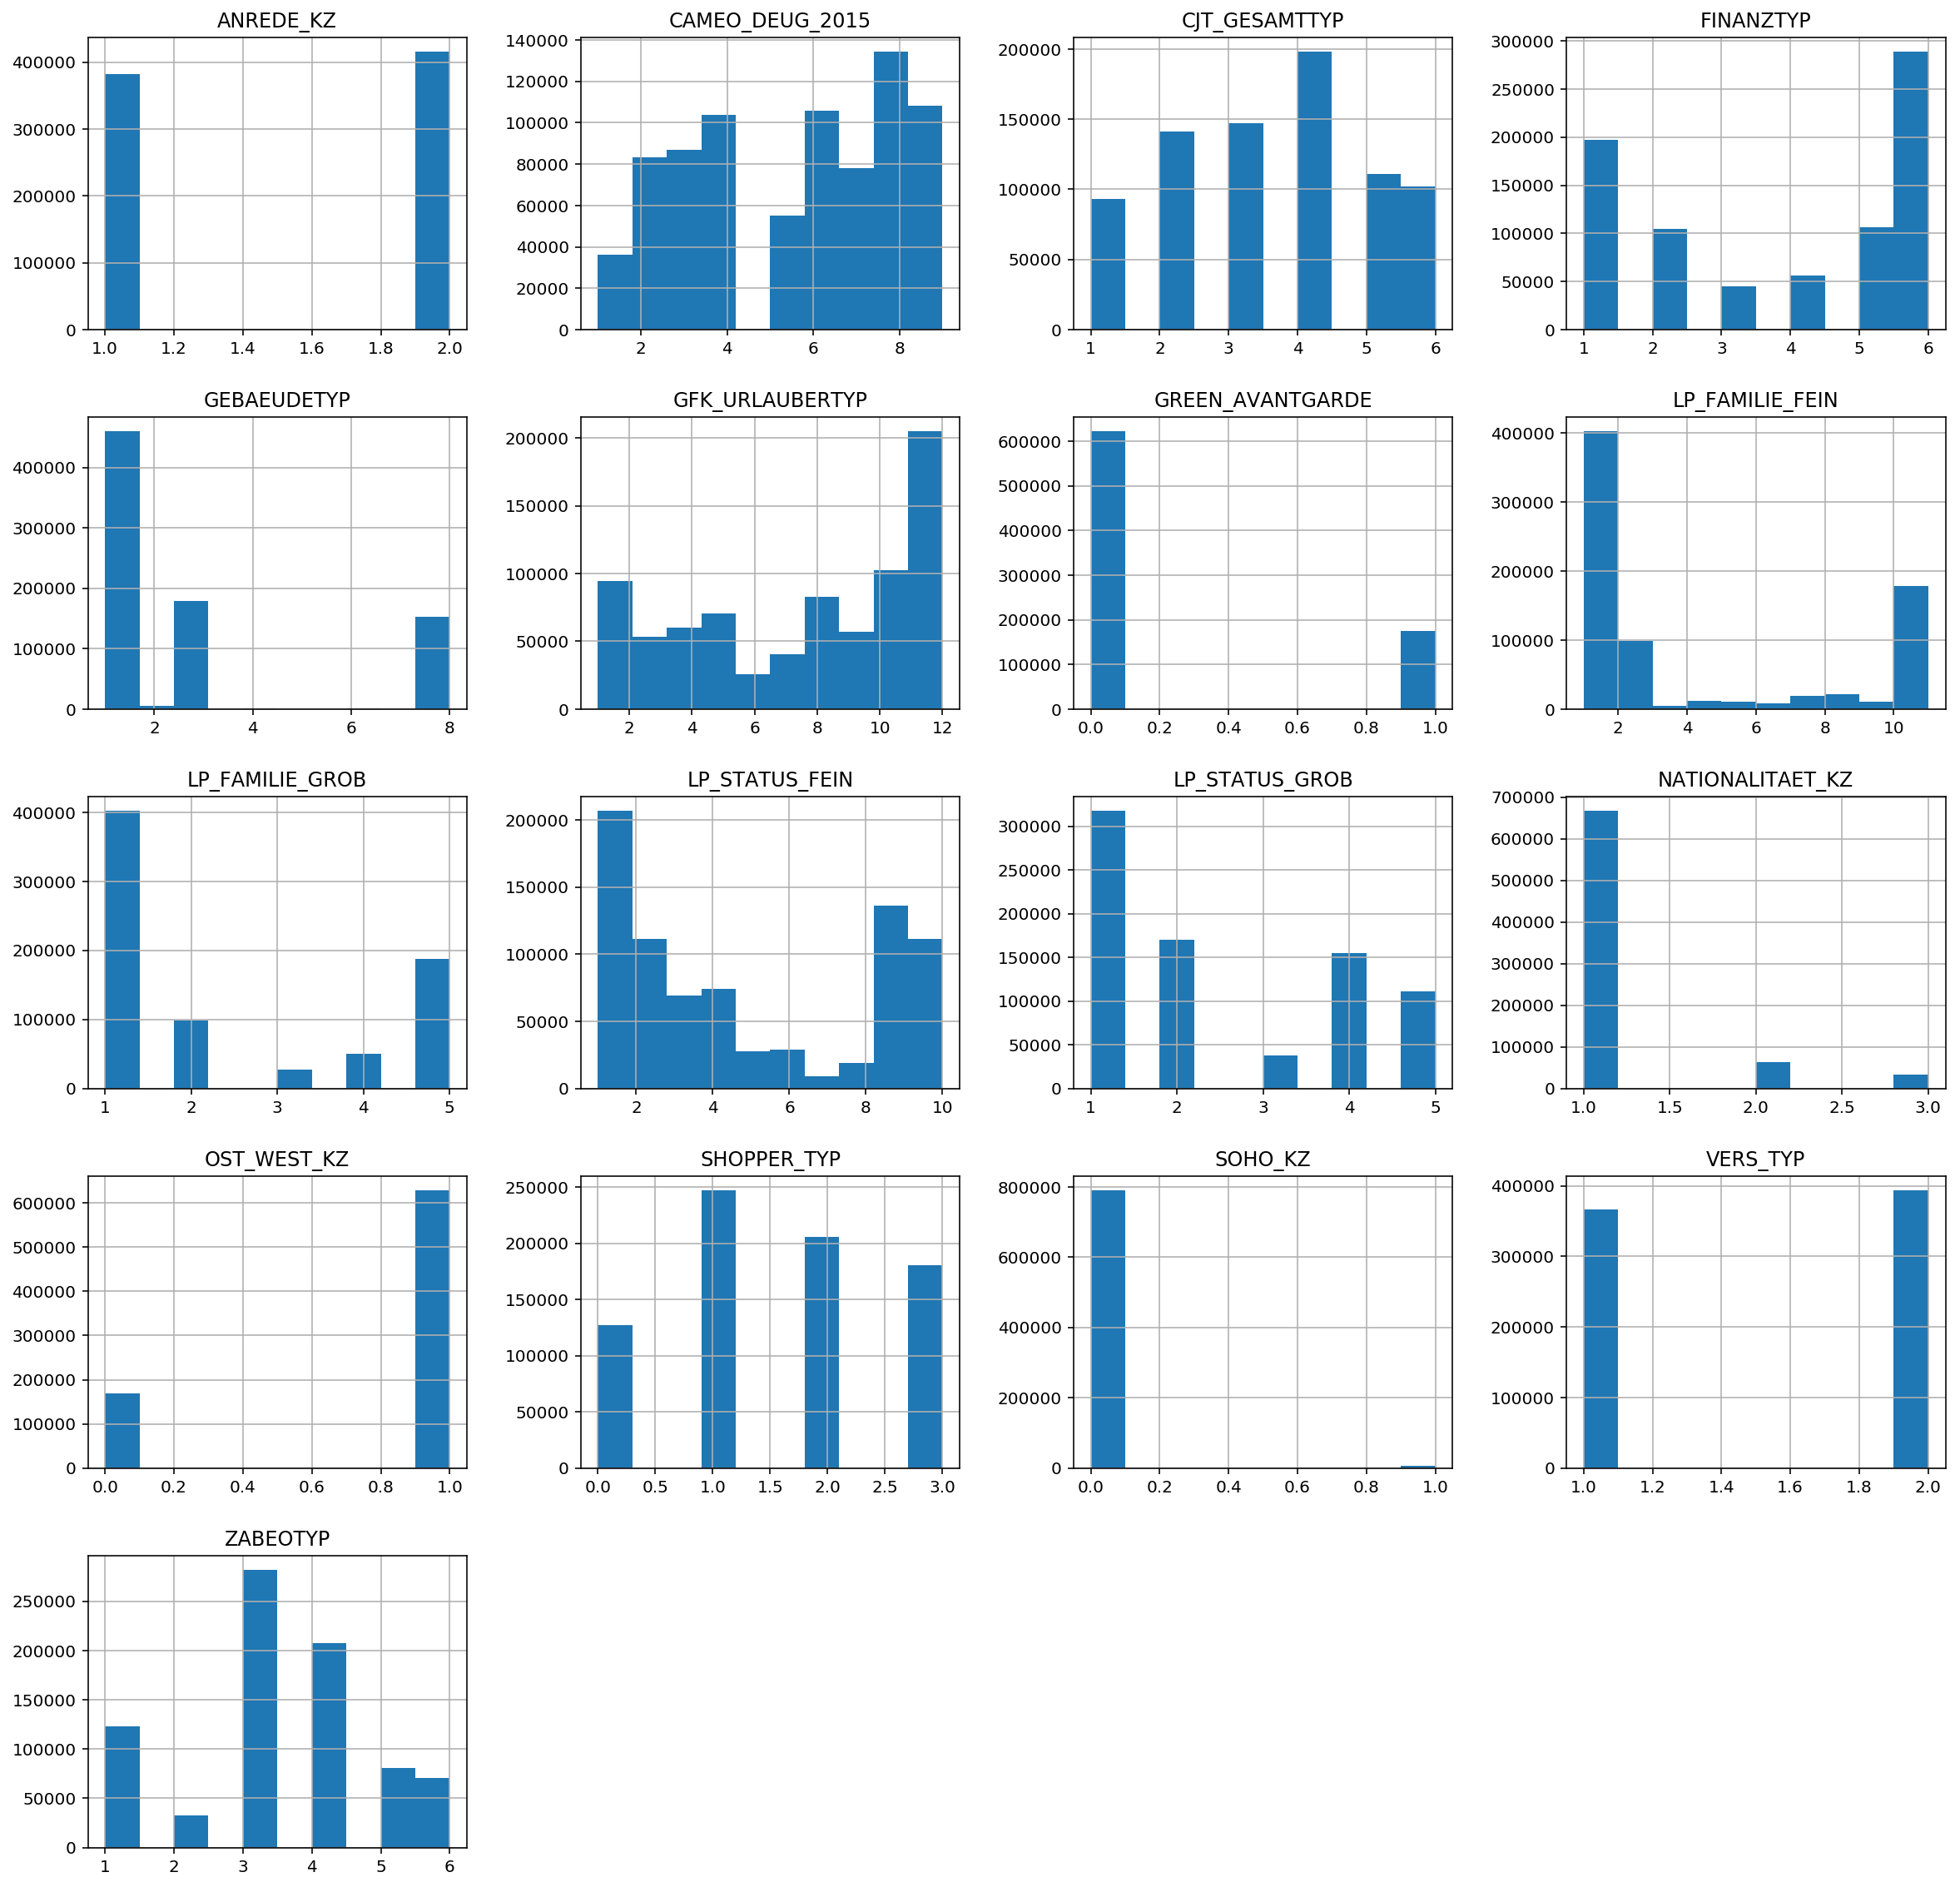

In [27]:
# update categorical_cols to reflect removal of Cameo Deu
new_cat_cols = list(filter(lambda x: x != 'CAMEO_DEU_2015', categorical_cols))
azdias_final[new_cat_cols].hist(figsize=(20,20))

In [28]:
# Get a list of categorical columns that have more than 2 values
new_cat_cols = list(filter(lambda x: azdias_final[x].value_counts().shape[0] > 2, new_cat_cols))
print(new_cat_cols)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [29]:
azdias_final = one_hot_multi_cats(azdias_final, new_cat_cols)


In [99]:
azdias_final.shape

(797837, 200)

#### Discussion 1.2.1: Re-Encode Categorical Features


I decided to keep all of the categorical features because it is fairly easy to reencode them.  Even though CAMEO_DEUG_2015 and CAMEO_DEU_2015 represent the same data at different levels of granularity I decided to keep both for now.  I started by making a list of all of the categorical features in data set and checking to see if they were numeric or not.  Ost_West_KZ was binary but not numeric so I re-encoded it as numeric data.  CAMEO_DEUG_2015 was encoded as string representations of numbers so I converted it to numeric data using the pandas to_numeric function.  Finaly the CAMEO_DEU_2015 data was another multi-level categorical encoded as a list of alphanumeric strings that represented different categories.  Because the alphanumeric strings were not very meaningful, I used a dictionary to replace these strings with the categories they represented.  Then I used one-hot encoding to create new binary categories for this.  The rest of the categorical data was numeric and split between binary and multi-level categories.  I wrote a function to one-hot encode the multi-level categoricals. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [31]:
# Get a list of mixed columns
mixed = updated_feat_info.where(lambda df: df['type']=='mixed').dropna()
mixed_cols = list(mixed.attribute.values)
mixed_cols = list(filter(lambda x: x not in to_remove_cols, mixed_cols))
print(mixed_cols)

['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [32]:
def get_cols_by_type(feat_info, typeSt):
    cols = feat_info.where(lambda df: df['type'] == typeSt).dropna()
    cols = list(cols.attribute.values)
    return cols

In [33]:
# Dictionaries for parsing PRAEGENDE_JUGENDJAHRE
praegende_ju_dict = {
'1.0': 'Mainstream',
'2.0': 'Avantgarde',
'3.0': 'Mainstream',
'4.0': 'Avantgarde',
'5.0': 'Mainstream',
'6.0': 'Avantgarde',
'7.0': 'Avantgarde',
'8.0': 'Mainstream',
'9.0': 'Avantgarde',
'10.0': 'Mainstream',
'11.0': 'Avantgarde',
'12.0': 'Mainstream',
'13.0': 'Avantgarde',
'14.0': 'Mainstream',
'15.0': 'Avantgarde',
}
p_jugendjahre_dict = {
'1.0': '40',
'2.0': '40',
'3.0': '50',
'4.0': '50',
'5.0': '60',
'6.0': '60',
'7.0': '60',
'8.0': '70',
'9.0': '70',
'10.0': '80',
'11.0': '80',
'12.0': '80',
'13.0': '80',
'14.0': '90',
'15.0': '90',
}

In [34]:
def clean_P_J(df):
    df['PRAEGENDE_MOVE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: '{:.1f}'.format(x)).replace(praegende_ju_dict)
    df['PRAEGENDE_MOVE'] = df['PRAEGENDE_MOVE'].replace({'Mainstream': 0, 'Avantgarde': 1})
    df['PRAEGENDE_YEAR'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: '{:.1f}'.format(x)).replace(p_jugendjahre_dict)
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    return df
azdias_final = clean_P_J(azdias_final)
azdias_final['PRAEGENDE_YEAR'].head()
azdias_final['PRAEGENDE_MOVE'].head()

1    0
2    1
3    0
4    0
5    0
Name: PRAEGENDE_MOVE, dtype: object

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def clean_cameo_intl(df):
    df['CAMEO_INTL_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: np.floor(float(x)/10))
    df['CAMEO_INTL_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: float(x) % 10)
    
    df = one_hot_multi_cats(df, ['CAMEO_INTL_LIFESTAGE', 'CAMEO_INTL_WEALTH'])
    
    return df
azdias_final = clean_cameo_intl(azdias_final)

In [36]:
def drop_cols(df, cols):
    for col in cols:
        if(col  in df.columns.values):
            df.drop([col], axis=1, inplace=True)
    return df

azdias_final = drop_cols(azdias_final, mixed_cols)


#### Discussion 1.2.2: Engineer Mixed-Type Features

For the mixed types I dropped every mixed column except the PRAEGENDE_JUGENDJAHRE column and the CAMEO_INTL_2015 column because most of them contained data that would be difficult to reencode and that was represented elsewhere in the dataframe.  The mixed features that I kept I split into multiple features. The PRAEGENDE column I split into two new columns, one that represented the decade of the person and another that represented the main movement of the time either avantgarde or mainstream.  This second column I re-encoded as numeric data with avantgarde being represented by a 1 and mainstream with 0.   The CAMEO column was also split into two new columns.  Then both of these new columns were re-encoded using one-hot encoding to create several new dummy variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [37]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# azdias_final.hist(figsize=(20,20))


In [38]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [39]:
def drop_bad_rows(df, threshold=0.3):
#     calculate NAN values per row and find rows missing more than threshold value. Default is 30% of the data
    nans_per_row = df.isnull().sum(axis=1)
    prop_nans_per_row = nans_per_row/df.shape[1]
    rows_to_remove = prop_nans_per_row.where(lambda x: x > threshold).dropna()
#     get a list of the indexes of rows missing more than threshold and remove from df
    to_remove_rows = list(rows_to_remove.index.values)
    clean_df = df.drop(to_remove_rows)
    return clean_df

In [40]:
def clean_data(df, rows=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    nan_df = insert_nan(df, feat_info)
    nan_df.replace('nan', np.nan, inplace=True)

    # remove selected columns and rows, ...
    clean_df = drop_cols(nan_df, to_remove_cols)
    
    if rows == True:
        clean_df = drop_bad_rows(clean_df)
    else:
        print('Unclean rows')
    # select, re-encode, and engineer column values.
        # handle categorical info columns including special OST_WEST column
    categorical_cols = get_cols_by_type(feat_info, 'categorical')
    re_encoded_df = one_hot_multi_cats(clean_df, categorical_cols)
    re_encoded_df.replace({'OST_WEST_KZ': {'O':0, 'W':1}}, inplace=True)
        # handle mixed info columns including special CAMEO_INTL and PRAEGENDE_JUGENDEJAHRE columns
    mixed_cols = get_cols_by_type(feat_info, 'mixed')
    re_encoded_df = clean_P_J(re_encoded_df)
    re_encoded_df = clean_cameo_intl(re_encoded_df)
    
    re_encoded_df = drop_cols(re_encoded_df, mixed_cols)
    
    # Return the cleaned dataframe.
    return re_encoded_df
    

In [41]:
clean_az = clean_data(azdias)
clean_az.shape

(797837, 200)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

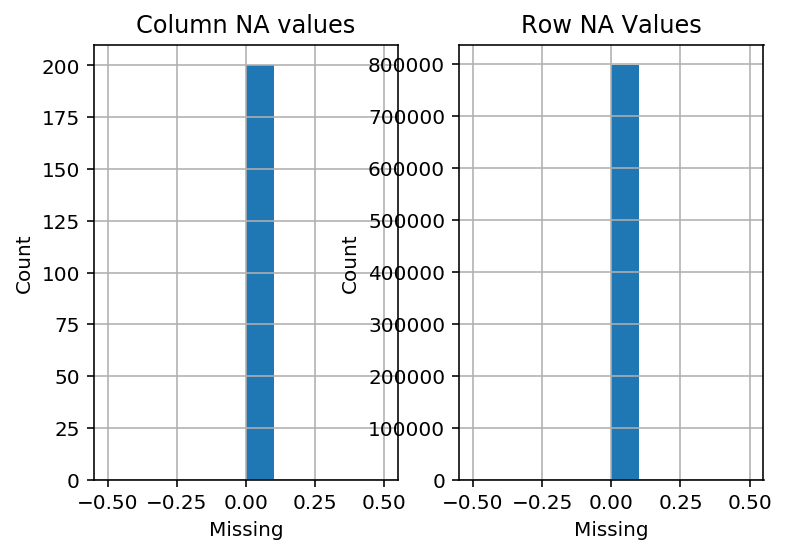

In [42]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

def final_clean_check(df):
# impute using default values to replace ('Nan/np.nan') with mean values for each column
    imputer = Imputer(axis=1)

    checked = df.replace('nan', np.nan)
    checked = pd.DataFrame(imputer.fit_transform(checked), columns=checked.keys())
    
    na_columns = checked.isnull().sum()/checked.shape[0]
    na_rows = checked.isnull().sum(axis=1)/checked.shape[1]

    plt.subplot(121)
    plt.title('Column NA values')
    na_columns.hist()
    plt.xlabel('Missing')
    plt.ylabel('Count')
    plt.subplot(122)
    na_rows.hist()
    plt.xlabel('Missing')
    plt.ylabel('Count')
    plt.title('Row NA Values')
    plt.show()

    return checked
# azf = final_clean_check(azdias_final)
clean_az = final_clean_check(clean_az)

In [43]:
clean_az.isnull().sum().sum()

0

In [44]:
clean_az.shape

(797837, 200)

In [45]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler(with_mean=False, with_std=False).fit(clean_az)

scaled_azdias = scaler.transform(clean_az)


### Discussion 2.1: Apply Feature Scaling


Because only a small fraction of my data had missing values, I decided to try dropping those values from my analysis.  Then I went with the suggested standard scaling which scales each feature to a mean of 0 and a standard deviation of 1. 


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
pca_azdias = PCA()
new_azdias = pca_azdias.fit_transform(scaled_azdias)


In [47]:
new_azdias.shape

(797837, 200)

In [48]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_azdias_red = PCA(n_components=10).fit(scaled_azdias)
new_azdias_reduced = pca_azdias_red.transform(scaled_azdias)




Text(0.5,1,'Explained Variance Per Principal Component')

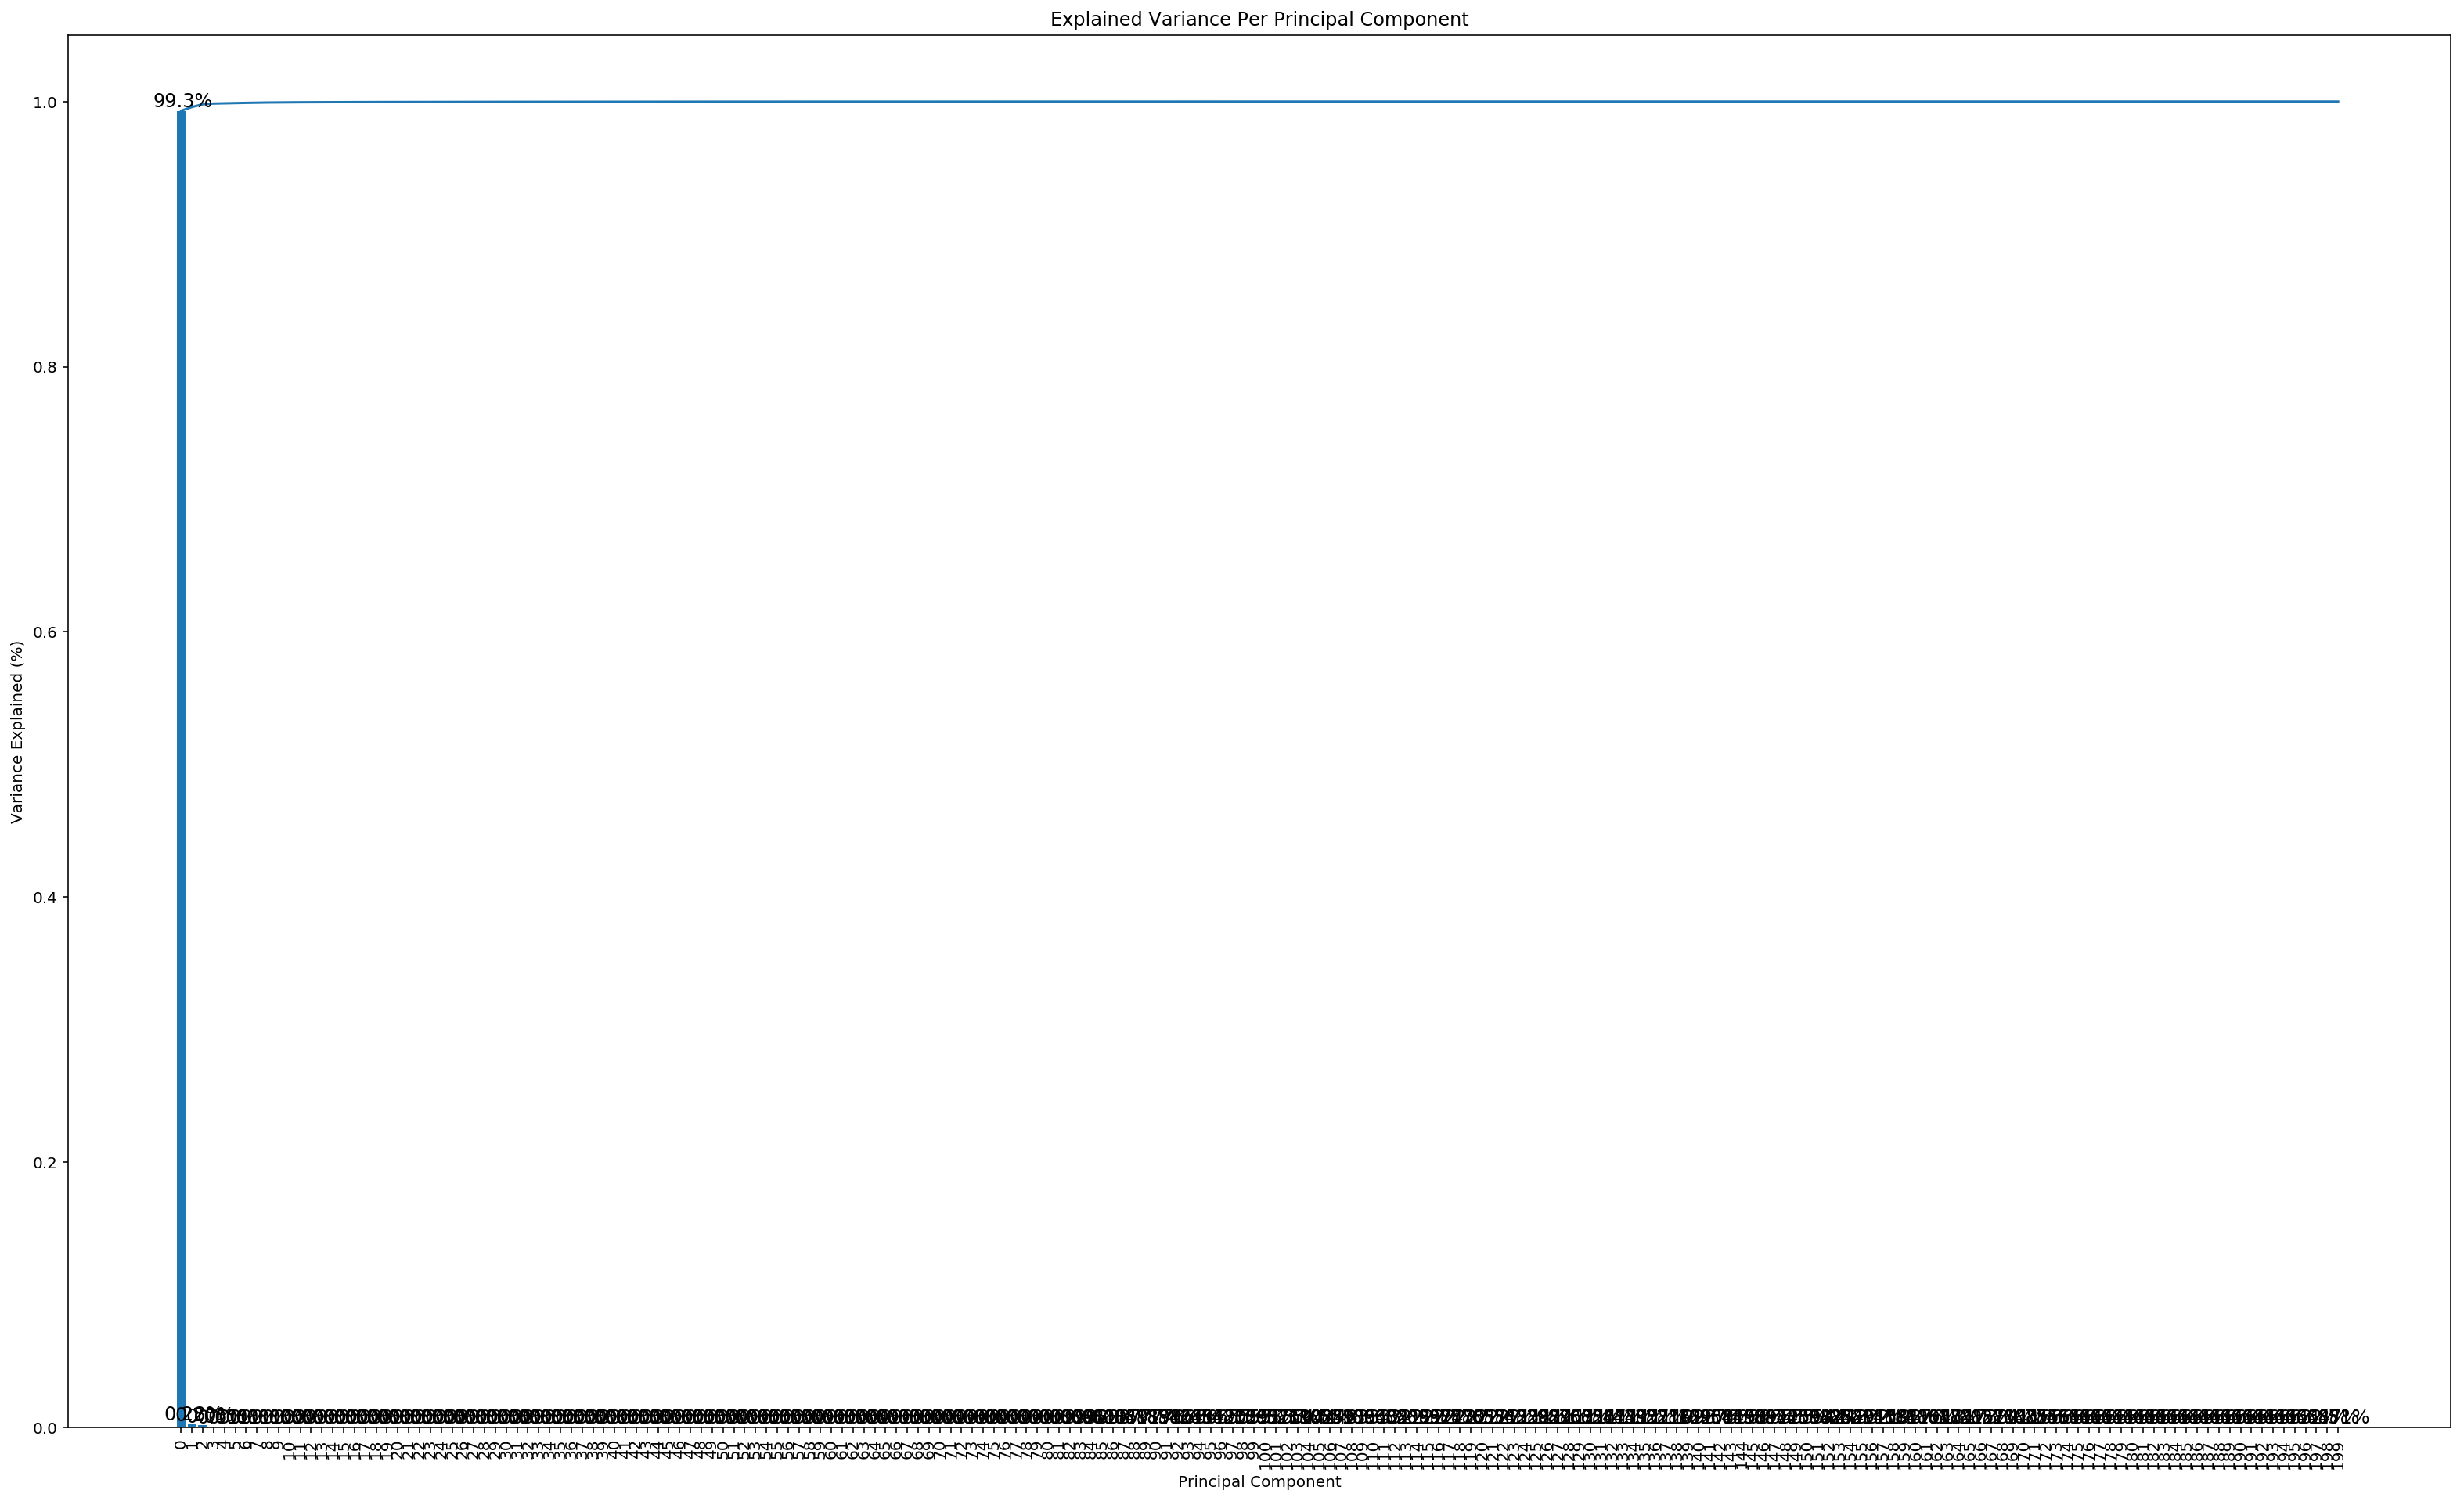

In [49]:
# Investigate the variance accounted for by each principal component.
y = pca_azdias.explained_variance_ratio_

x = list(np.arange(new_azdias.shape[1]))
plt.figure(figsize=(60,36))
ax = plt.subplot(221)
ax.bar(x, y,)
cumvals = np.cumsum(y)
ax.plot(x, cumvals)

for i in range(len(y)):
        ax.annotate(r"%s%%" % ((str(y[i]*100)[:4])), (x[i]+0.2, y[i]), va="bottom", ha="center", fontsize=12)
        
plt.xticks(np.arange(len(x)), x, rotation='vertical')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')

In [104]:
print(y[:10].sum())
print(y[:5].sum())

0.999358120609
0.998693134246


Text(0.5,1,'Explained Variance Per Principal Component')

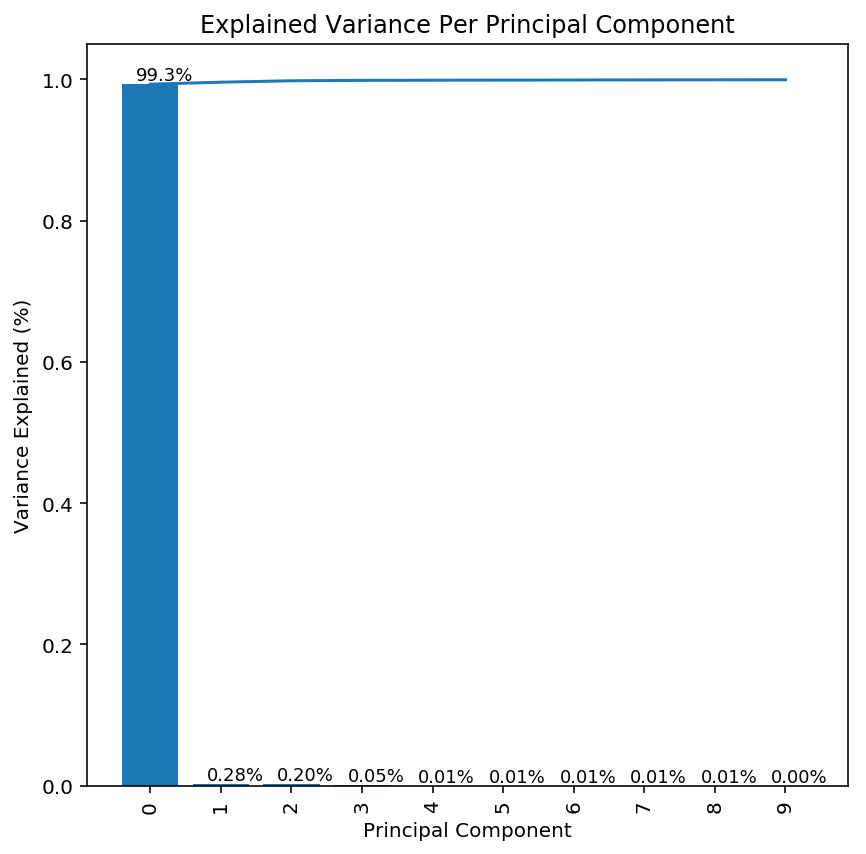

In [51]:
y2 = pca_azdias_red.explained_variance_ratio_

x2 = list(np.arange(new_azdias_reduced.shape[1]))
plt.figure(figsize=(15,15))
ax = plt.subplot(221)
ax.bar(x2, y2,)
cumvals = np.cumsum(y2)
ax.plot(x2, cumvals)

for i in range(len(y2)):
        ax.annotate(r"%s%%" % ((str(y2[i]*100)[:4])), (x2[i]+0.2, y2[i]), va="bottom", ha="center", fontsize=9)
        
plt.xticks(np.arange(len(x2)), x2, rotation='vertical')
ax.set_xlabel("Principal Component")
ax.set_ylabel("Variance Explained (%)")
plt.title('Explained Variance Per Principal Component')



### Discussion 2.2: Perform Dimensionality Reduction
This was an interesting data set because it seems that the majority of the variance can be represented by one principal component and 99.8% of the variance can be explained using the first 5 principal components.  In my analysis, I decided to be conservative and include the top 10 principal components which accounted for greater than 99.9% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def nth_component_weights(df, pca, nth):
    components = pca.components_
    dimensions = list(np.arange(1, len(components) + 1))
    components_df = pd.DataFrame(np.round(components, 4), columns=df.keys())
    components_df.index = dimensions
    return components_df.iloc[nth].sort_values(ascending=False)


# This component is related to a person's age/formative decade and to a lesser degree to the number of households per building
print(nth_component_weights(clean_az, pca_azdias_red, 1))


ANZ_HAUSHALTE_AKTIV         0.1304
PRAEGENDE_MOVE              0.0861
SEMIO_LUST                  0.0557
W_KEIT_KIND_HH              0.0524
VERS_TYP                    0.0493
FINANZ_VORSORGER            0.0466
SEMIO_ERL                   0.0390
HEALTH_TYP                  0.0389
RETOURTYP_BK_S              0.0365
ALTERSKATEGORIE_GROB        0.0329
FINANZ_HAUSBAUER            0.0195
FINANZ_MINIMALIST           0.0194
WOHNDAUER_2008              0.0190
ZABEOTYP_3                  0.0130
SEMIO_KRIT                  0.0089
CJT_GESAMTTYP_2.0           0.0055
FINANZTYP_2                 0.0053
FINANZTYP_5                 0.0047
SEMIO_KAEM                  0.0044
ORTSGR_KLS9                 0.0044
ANZ_HH_TITEL                0.0039
EWDICHTE                    0.0035
CJT_GESAMTTYP_1.0           0.0032
SHOPPER_TYP_3.0             0.0025
LP_STATUS_FEIN_1.0          0.0024
RELAT_AB                    0.0022
CAMEO_INTL_LIFESTAGE_5.0    0.0022
LP_FAMILIE_FEIN_1.0         0.0022
LP_FAMILIE_GROB_1.0 

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# This component is related to a person's living situation/number of residences per building.
print(nth_component_weights(clean_az, pca_azdias_red, 2))

ANZ_HAUSHALTE_AKTIV         0.9784
PRAEGENDE_YEAR              0.1307
ORTSGR_KLS9                 0.0431
HH_EINKOMMEN_SCORE          0.0323
EWDICHTE                    0.0305
FINANZ_HAUSBAUER            0.0248
FINANZ_SPARER               0.0163
SEMIO_REL                   0.0124
SEMIO_PFLICHT               0.0122
LP_STATUS_GROB_1.0          0.0117
W_KEIT_KIND_HH              0.0117
SEMIO_FAM                   0.0116
RELAT_AB                    0.0114
SEMIO_SOZ                   0.0099
SEMIO_TRADV                 0.0092
PLZ8_ANTG3                  0.0091
SEMIO_KULT                  0.0091
PLZ8_ANTG4                  0.0090
CAMEO_INTL_WEALTH_5.0       0.0088
ANZ_HH_TITEL                0.0088
ARBEIT                      0.0085
SEMIO_MAT                   0.0082
SEMIO_RAT                   0.0080
LP_STATUS_FEIN_1.0          0.0080
GEBAEUDETYP_3.0             0.0070
CAMEO_INTL_LIFESTAGE_1.0    0.0066
CAMEO_DEUG_2015_9           0.0061
SEMIO_KAEM                  0.0059
FINANZ_ANLEGER      

In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# This component is related to living situation and contains features related to number of family houses per microcell,
# age of the building, movement patterns and purchasing power in region
print(nth_component_weights(clean_az, pca_azdias_red, 3))

KBA05_ANTG4                 0.3654
KBA05_ANTG3                 0.3520
KBA05_ANTG1                 0.3405
KBA05_ANTG2                 0.3393
MIN_GEBAEUDEJAHR            0.3179
MOBI_REGIO                  0.3047
KBA05_GBZ                   0.2995
KKK                         0.2319
REGIOTYP                    0.2041
PLZ8_ANTG4                  0.1479
PLZ8_ANTG1                  0.1458
PLZ8_GBZ                    0.1328
PLZ8_ANTG3                  0.1323
PLZ8_HHZ                    0.1207
PLZ8_ANTG2                  0.1203
ANZ_HAUSHALTE_AKTIV         0.1072
FINANZ_UNAUFFAELLIGER       0.0244
KONSUMNAEHE                 0.0230
ONLINE_AFFINITAET           0.0229
SEMIO_VERT                  0.0226
PRAEGENDE_MOVE              0.0214
INNENSTADT                  0.0203
SEMIO_MAT                   0.0193
FINANZ_MINIMALIST           0.0186
BALLRAUM                    0.0169
SEMIO_KRIT                  0.0164
LP_STATUS_GROB_4.0          0.0096
FINANZTYP_3                 0.0086
LP_STATUS_FEIN_9.0  

In [55]:
# This component relates to age, attitude towards health and insurance status, likelihood of children, 
# and personality and financial behavior, etc
print(nth_component_weights(clean_az, pca_azdias_red, 4))

SEMIO_ERL                0.1784
FINANZ_MINIMALIST        0.1201
FINANZ_VORSORGER         0.1192
SEMIO_LUST               0.0935
INNENSTADT               0.0915
MOBI_REGIO               0.0899
KBA05_ANTG1              0.0883
ALTERSKATEGORIE_GROB     0.0872
BALLRAUM                 0.0832
SEMIO_KRIT               0.0823
SEMIO_KAEM               0.0738
KONSUMNAEHE              0.0714
KBA05_GBZ                0.0712
SEMIO_DOM                0.0703
WOHNDAUER_2008           0.0669
ANZ_HAUSHALTE_AKTIV      0.0609
NATIONALITAET_KZ_1.0     0.0357
ANZ_PERSONEN             0.0324
PRAEGENDE_YEAR           0.0306
RETOURTYP_BK_S           0.0303
ZABEOTYP_3               0.0277
SHOPPER_TYP_3.0          0.0247
GEBAEUDETYP_RASTER       0.0239
ANREDE_KZ                0.0238
FINANZTYP_6              0.0237
CJT_GESAMTTYP_2.0        0.0187
FINANZTYP_2              0.0185
LP_STATUS_FEIN_9.0       0.0162
LP_STATUS_GROB_4.0       0.0157
LP_STATUS_FEIN_10.0      0.0122
                          ...  
ARBEIT  

In [56]:
# This compoenent strongly weights features related to neighborhood type/class features, purchasing power and PLZ8 regional descriptors.
print(nth_component_weights(clean_az, pca_azdias_red, 5))

PLZ8_ANTG3                  0.2921
PLZ8_ANTG4                  0.2841
PLZ8_ANTG2                  0.2628
PLZ8_HHZ                    0.2388
PLZ8_GBZ                    0.1917
PLZ8_ANTG1                  0.1785
ORTSGR_KLS9                 0.1506
SEMIO_DOM                   0.1311
SEMIO_KAEM                  0.1284
EWDICHTE                    0.1184
SEMIO_KRIT                  0.1106
SEMIO_ERL                   0.0785
KBA05_ANTG2                 0.0584
KBA05_ANTG3                 0.0584
RELAT_AB                    0.0483
FINANZ_HAUSBAUER            0.0481
HH_EINKOMMEN_SCORE          0.0477
KBA05_ANTG4                 0.0428
SEMIO_RAT                   0.0384
ANREDE_KZ                   0.0334
ARBEIT                      0.0278
SEMIO_LUST                  0.0247
PRAEGENDE_YEAR              0.0182
LP_STATUS_GROB_1.0          0.0146
ZABEOTYP_3                  0.0132
RETOURTYP_BK_S              0.0112
LP_STATUS_FEIN_1.0          0.0105
VERS_TYP                    0.0101
CAMEO_INTL_LIFESTAGE

In [57]:
# This component highly weights features related to personality and income.
print(nth_component_weights(clean_az, pca_azdias_red, 6))

SEMIO_VERT               0.3428
SEMIO_SOZ                0.2686
SEMIO_KULT               0.2599
SEMIO_FAM                0.2552
FINANZ_MINIMALIST        0.1181
SEMIO_REL                0.1021
SEMIO_MAT                0.0973
KBA05_ANTG1              0.0642
PLZ8_ANTG1               0.0615
MOBI_REGIO               0.0587
KBA05_GBZ                0.0538
PLZ8_GBZ                 0.0521
INNENSTADT               0.0396
PLZ8_ANTG4               0.0345
FINANZ_VORSORGER         0.0341
BALLRAUM                 0.0337
PLZ8_HHZ                 0.0321
RETOURTYP_BK_S           0.0321
PLZ8_ANTG2               0.0288
SHOPPER_TYP_0.0          0.0269
ANZ_HAUSHALTE_AKTIV      0.0265
PLZ8_ANTG3               0.0244
ZABEOTYP_1               0.0242
ANZ_PERSONEN             0.0241
KBA05_ANTG2              0.0239
KBA05_ANTG4              0.0220
WOHNDAUER_2008           0.0187
FINANZTYP_5              0.0183
KONSUMNAEHE              0.0164
GREEN_AVANTGARDE         0.0160
                          ...  
ZABEOTYP

### Discussion 2.3: Interpret Principal Components

   When a principal component has very high or very low weights for certain features that suggests that that principal component might be representing those features.  Positive values indicate a positive relationship while negative values indicate an inverse of opposite relationship.  When I examined the feature weights for the top 6 principal components, I found that the first principal component had one very highly weighted feature which related to the age/formative decade of the person and one less highly weighted feature that corresponded to the number of residences per building.  The second principal component had one heavily weighted feature that related to a person's living situation/number of residences per building. The third principal component had several heavily weighted features that related to living situation such as the number of family houses per microcell, age of the building, movement patterns and purchasing power in region.  The fourth principal component had several weighted features that related to age, attitude towards health and insurance status, likelihood of having children, 
as well as some features that related to personality and financial behavior, etc. The fifth seemed to represent neighborhood type/class features, purchasing power and PLZ8 regional descriptors while the sixth had several highly weighted features related to personality and income level.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [58]:
# Over a number of different cluster counts...
def get_kmeans_score(data, num_clusters):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=num_clusters, random_state=3).fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(data))
    
    return score

num_centers = list(range(3, 30, 3))
scores = []

# Check kmean scores for a range of k values
# Commented out to allow for quicker initialization of notebook
# with active_session():
#         # do long-running work here
#     for centers in num_centers:
#         score = get_kmeans_score(new_azdias_reduced, centers)
#         scores.append(score)
    


In [59]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# plt.plot(num_centers, scores)
# plt.xlabel('K number of clusters')
# plt.ylabel('Average distance from centroid of cluster')
# plt.title('K vs Distance from Center')


In [60]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

population_kmeans = KMeans(n_clusters=9).fit(new_azdias_reduced)

pop_cluster_labels = population_kmeans.labels_
print(len(pop_cluster_labels))

797837


### Discussion 3.1: Apply Clustering to General Population


Even though the kmeans within cluster distance continued decreasing for all of the cluster numbers I tested the curve of distance vs number of clusters started to flatten between 6 and 15 clusters showing a diminishing return for the increased processing required.  Therefore, I decided to fit my data using 9 clusters which seemed likely to give me the best scores for my time.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

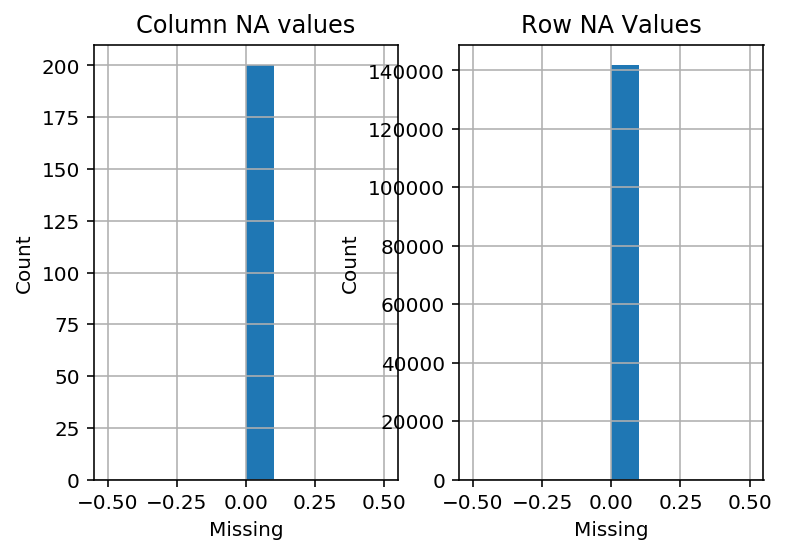

In [61]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers_clean = clean_data(customers)
customers_clean['GEBAEUDETYP_5.0'] = 0
customers_clean = final_clean_check(customers_clean)

In [62]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_scaled_data = scaler.transform(customers_clean)


In [63]:

customer_reduced = pca_azdias_red.transform(customer_scaled_data)

In [64]:
cust_cluster_labels = population_kmeans.predict(customer_reduced)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [65]:
# Get proportion of customer rows missing 30% or more of the data
c_nans_per_row = customers.isnull().sum(axis=1)
c_prop_nans_per_row = c_nans_per_row/customers.shape[1]

c_rows_to_remove = c_prop_nans_per_row.where(lambda x: x > 0.3).dropna()
c_to_remove_rows = list(c_rows_to_remove.index.values)
print('Number of rows to drop:', len(c_to_remove_rows))
print('About {} percent of the rows are missing greater than 30% of the data'.format(len(c_to_remove_rows)/customers.shape[0]*100))

Number of rows to drop: 49962
About 26.069125289587376 percent of the rows are missing greater than 30% of the data


In [66]:
# Create and clean datasets for the sparse rows segments of the customer and population datasets and fill missing categorical columns 
# with 0s
pop_dropped = clean_data(azdias_dropped, rows=False)

cust_dropped = customers.copy().iloc[c_to_remove_rows]
cust_dropped = clean_data(cust_dropped, rows=False)


pop_missing = list(filter(lambda x: x not in pop_dropped.columns.values, clean_az.columns.values))
cust_missing = list(filter(lambda x: x not in cust_dropped.columns.values, customers_clean.columns.values))

for missing in pop_missing:
    pop_dropped[missing] = 0.0
for missing in cust_missing:
    cust_dropped[missing] = 0.0
    
cust_dropped = final_clean_check(cust_dropped)
pop_dropped = final_clean_check(pop_dropped)

Unclean rows
Unclean rows


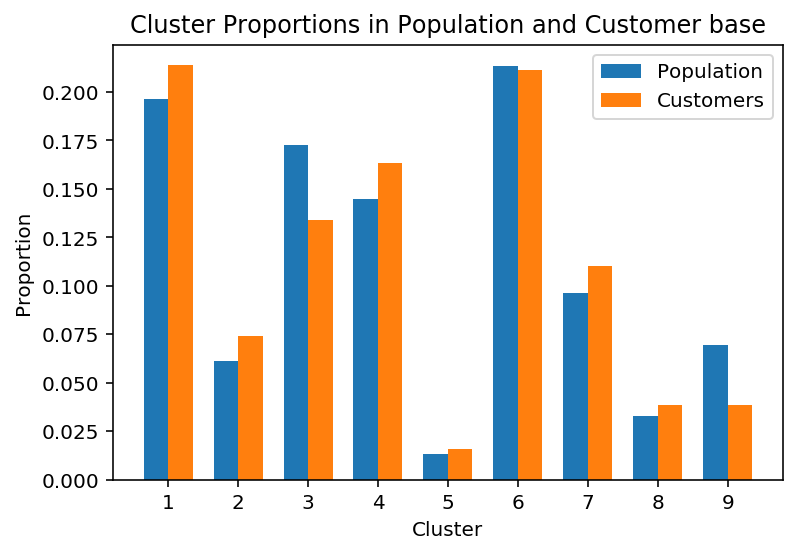

In [71]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
pop_clusters = pd.Index(pop_cluster_labels)
cust_clusters = pd.Index(cust_cluster_labels)

pop_cluster_proportions = pop_clusters.value_counts()/pop_clusters.value_counts().sum()
cust_cluster_proportions = cust_clusters.value_counts()/cust_clusters.value_counts().sum()


x = np.arange(1,10)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pop_cluster_proportions.sort_index().values, width, label='Population')
rects2 = ax.bar(x + width/2, cust_cluster_proportions.sort_index().values, width, label='Customers')

ax.set_ylabel('Proportion')
ax.set_title('Cluster Proportions in Population and Customer base')
ax.set_xticks(x)
ax.set_xticklabels(pop_cluster_proportions.sort_index().index + 1)
ax.set_xlabel('Cluster')
ax.legend()


In [72]:
clean_az_clustered = clean_az.copy()
clean_az_clustered['Cluster'] = pop_clusters

In [73]:
clean_az_clustered['Cluster'].head()

0    6
1    3
2    0
3    5
4    1
Name: Cluster, dtype: int64

In [74]:
over_represented = clean_az_clustered.where(clean_az_clustered['Cluster'] == 0).dropna()


In [75]:


def get_cluster(df_reduced, label, cluster, df_full=clean_az):
    pop = pd.DataFrame(df_reduced, columns=np.arange(0,10))
    pop['Cluster'] = label
    
    
    pop_cluster = pop.where(pop['Cluster'] == cluster).dropna()
    pop_cluster.drop(['Cluster'], axis=1, inplace=True)
    
    cluster_unpca = pca_azdias_red.inverse_transform(pop_cluster)
    cluster_unpca = pd.DataFrame(cluster_unpca, columns=df_full.keys())
    cluster_unscaled = scaler.inverse_transform(cluster_unpca)
    cluster_unscaled = pd.DataFrame(cluster_unpca, columns=df_full.keys())
    
    return cluster_unscaled

cluster2 = get_cluster(new_azdias_reduced, pop_clusters, 2)

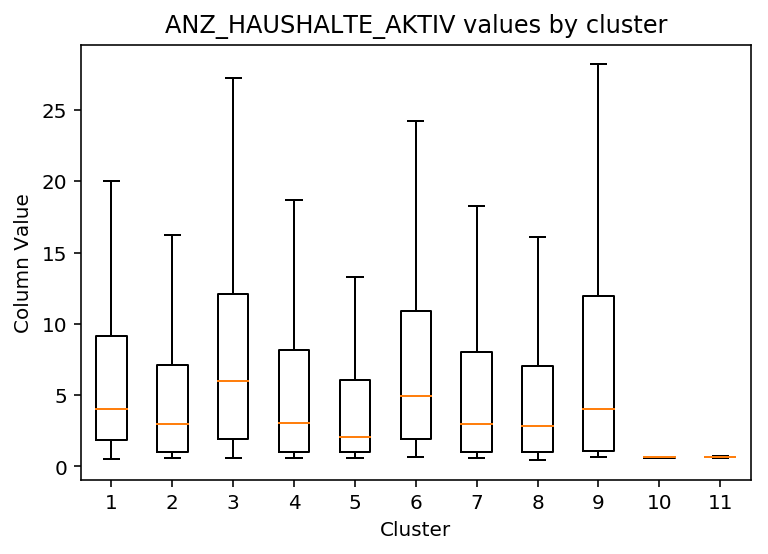

In [76]:
def get_boxplots(column, n=9):
    clusters = []
    for i in range(n):
        cluster = get_cluster(new_azdias_reduced, pop_clusters, i)
        clusters.append(cluster[column])
    clusters.append(cust_dropped[column])
    clusters.append(pop_dropped[column])
    fig, ax = plt.subplots()
    ax.boxplot(clusters, 0, '')

    plt.xlabel('Cluster')
    plt.ylabel('Column Value')
    plt.title('{} values by cluster'.format(column))
    plt.show()

get_boxplots('ANZ_HAUSHALTE_AKTIV')

In [98]:
checking = customers.copy().iloc[c_to_remove_rows]

checking['FINANZ_HAUSBAUER'].value_counts()

3    47349
2     1656
1      918
4       38
5        1
Name: FINANZ_HAUSBAUER, dtype: int64

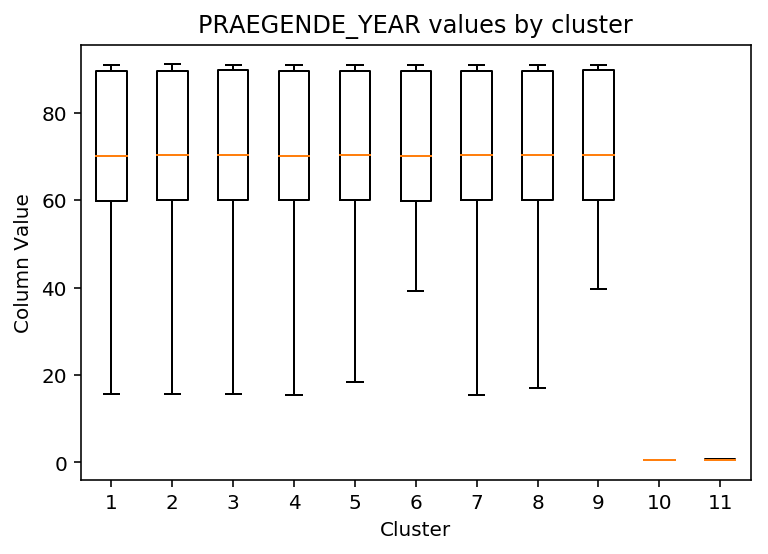

In [77]:
get_boxplots('PRAEGENDE_YEAR')

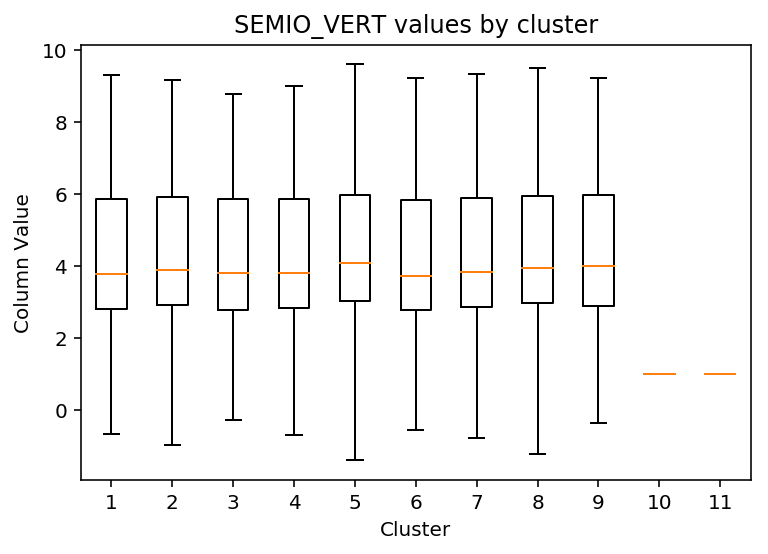

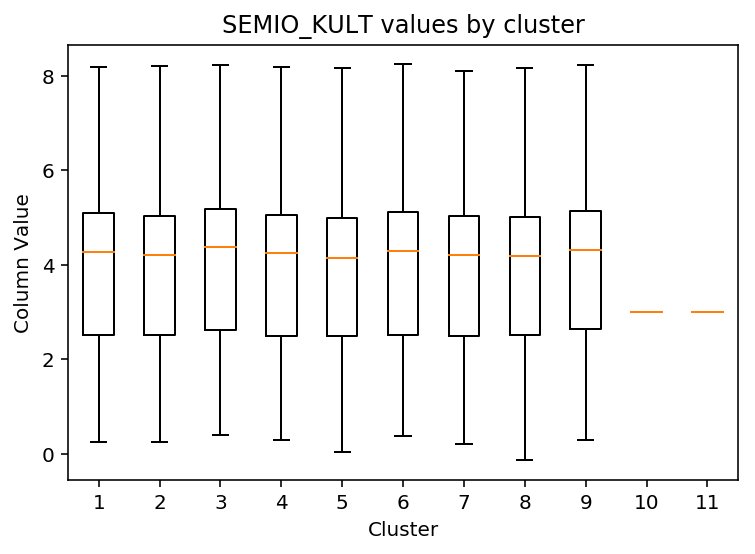

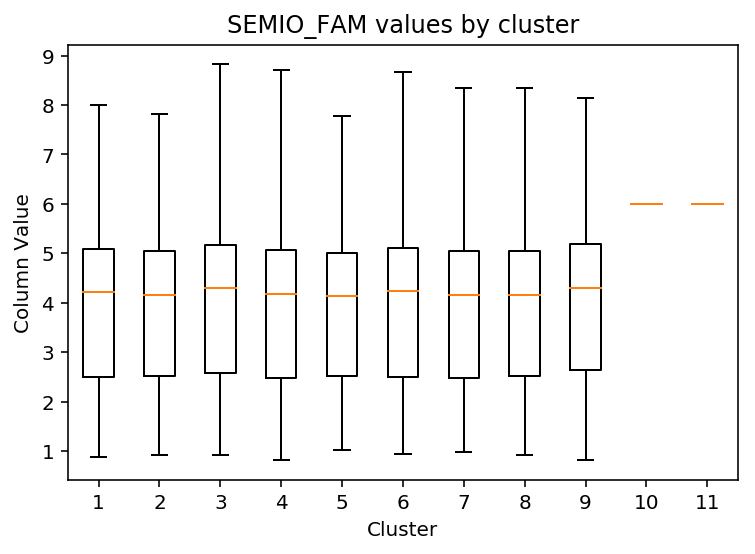

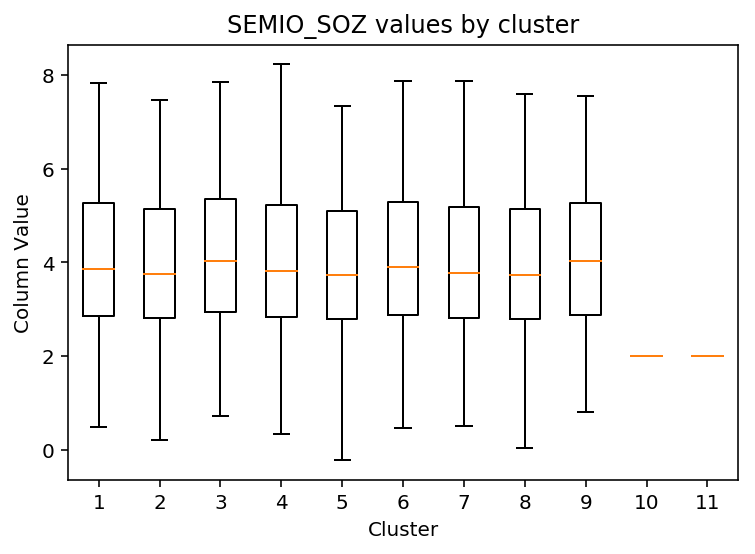

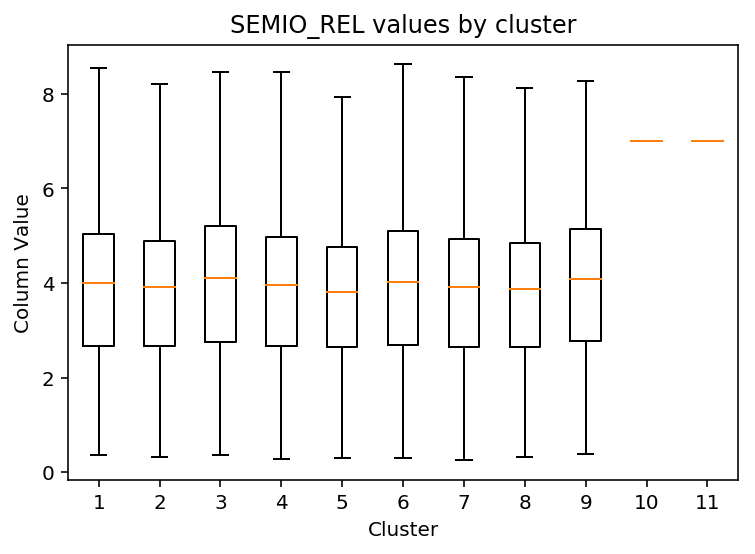

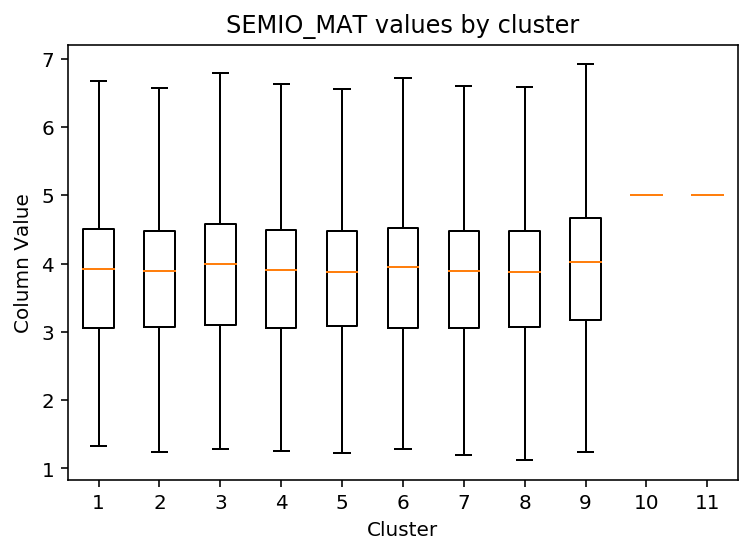

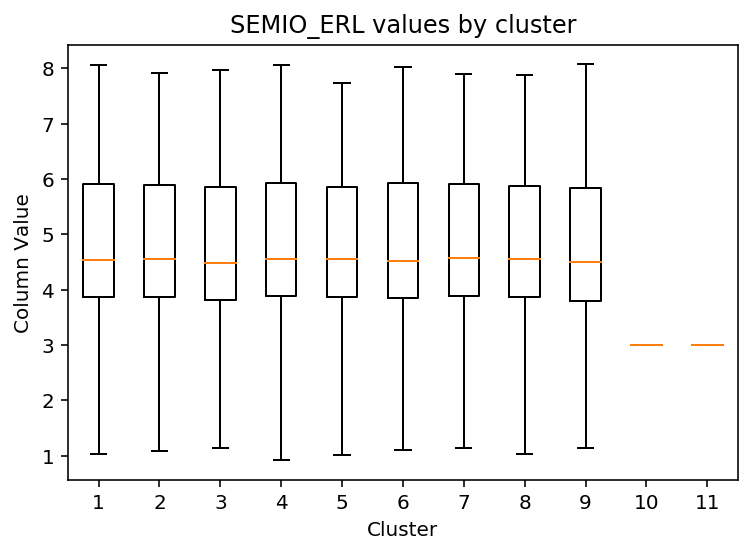

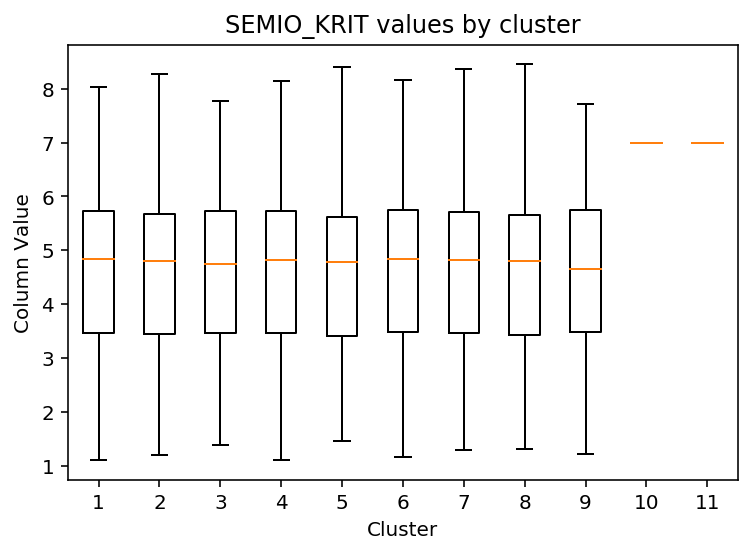

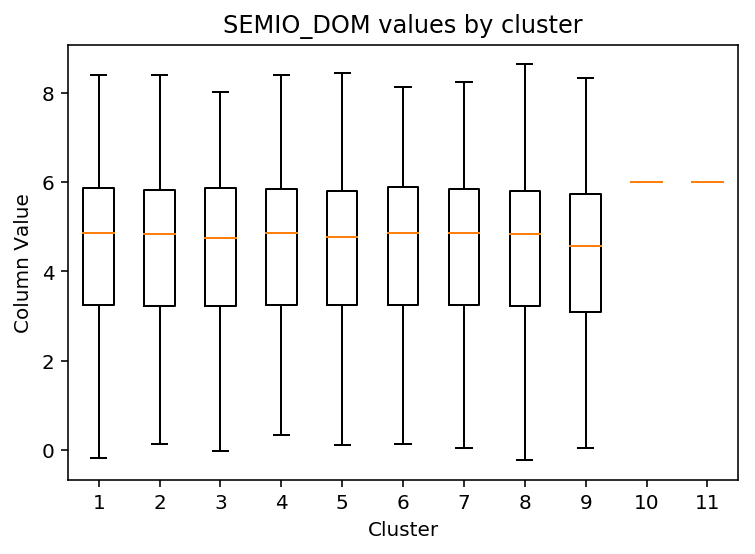

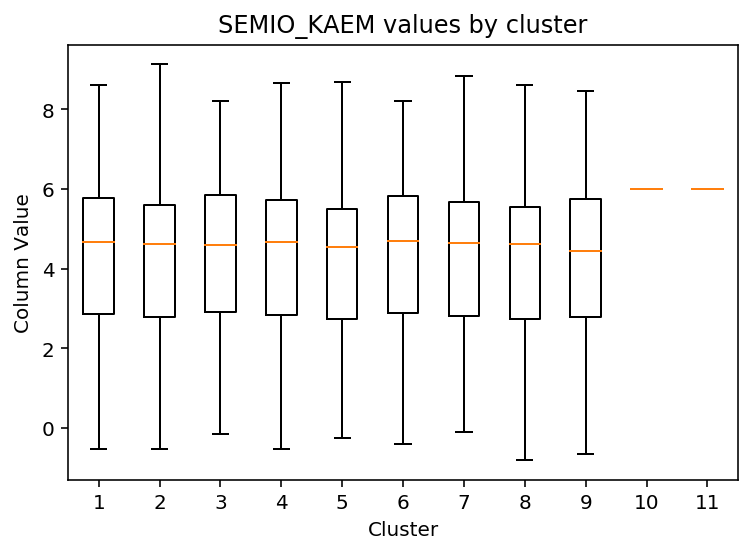

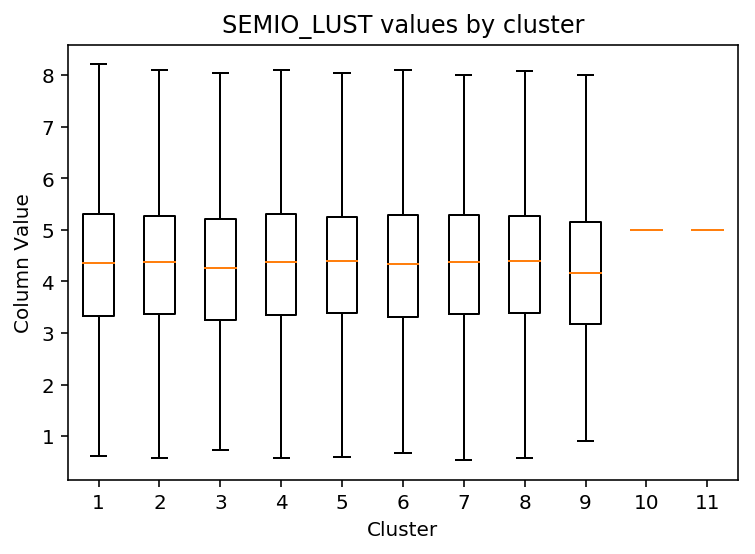

In [78]:
cols_to_compare = ['SEMIO_VERT',
                   'SEMIO_KULT',
                   'SEMIO_FAM',
                   'SEMIO_SOZ',
                   'SEMIO_REL',
                   'SEMIO_MAT',
                   'SEMIO_ERL',
                   'SEMIO_KRIT',
                   'SEMIO_DOM',
                   'SEMIO_KAEM',
                  'SEMIO_LUST']

for col in cols_to_compare:
    get_boxplots(col)

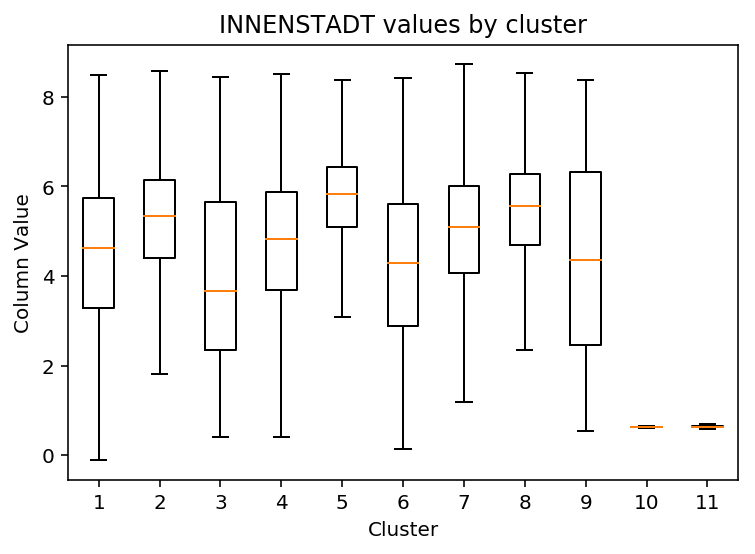

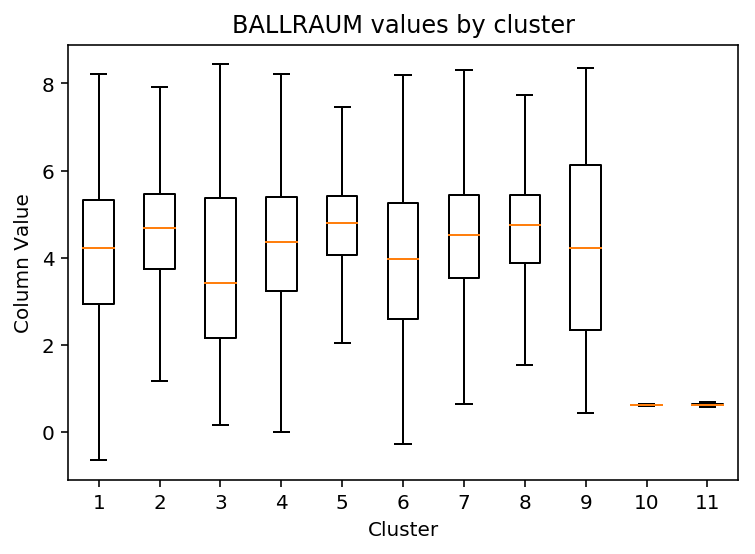

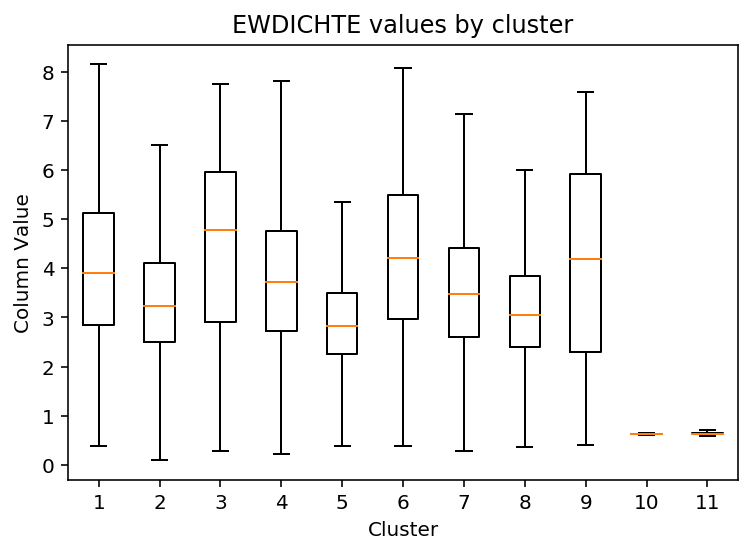

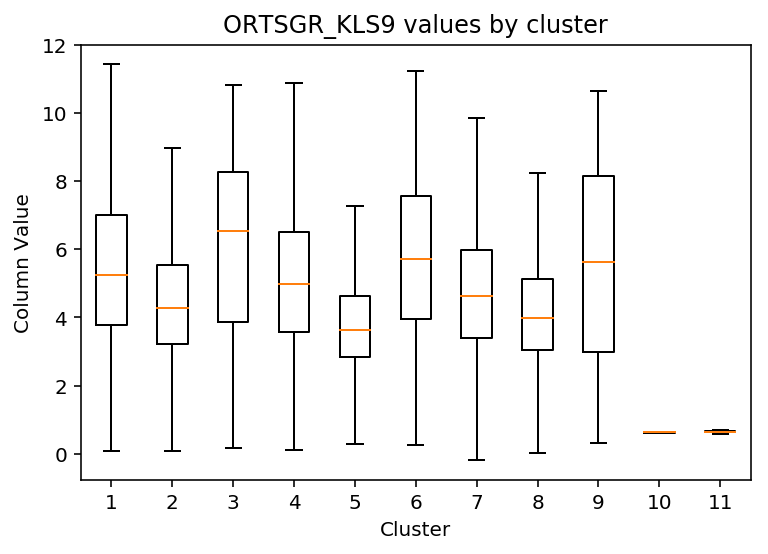

In [79]:
col_urbanity_travel = [
    'INNENSTADT',
    'BALLRAUM',
    'EWDICHTE',
    'ORTSGR_KLS9'   
]
for col in col_urbanity_travel:
    get_boxplots(col)

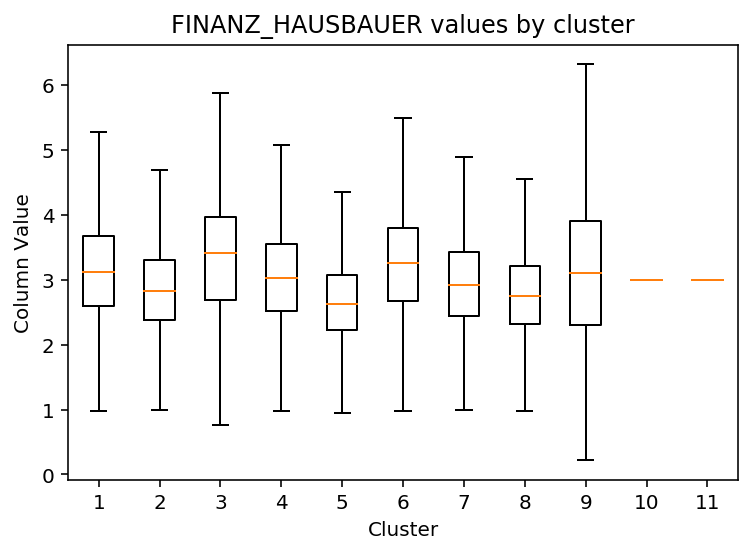

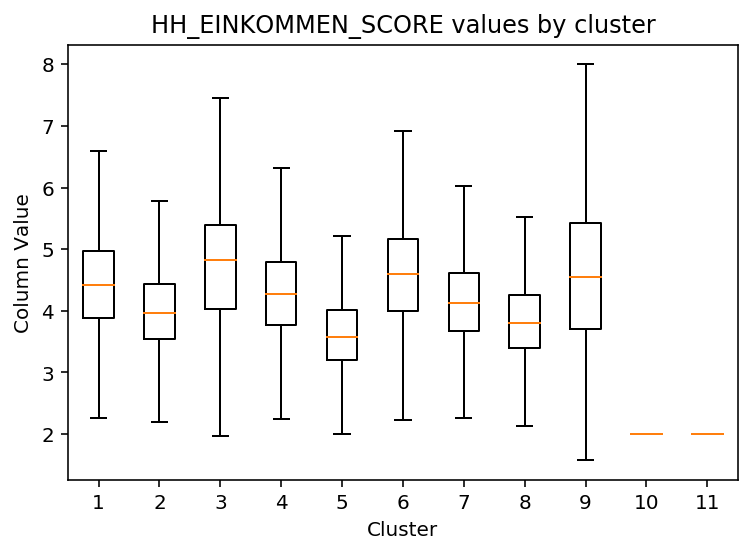

In [81]:
get_boxplots('FINANZ_HAUSBAUER')
get_boxplots('HH_EINKOMMEN_SCORE')

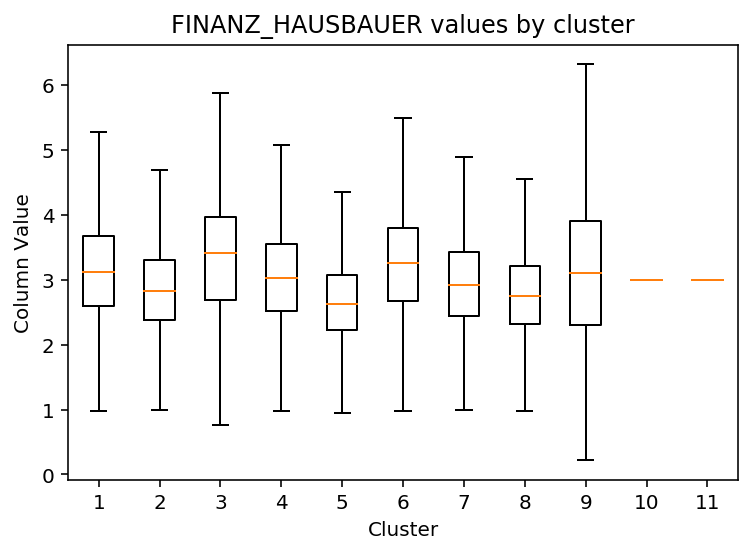

In [82]:
get_boxplots('FINANZ_HAUSBAUER')

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# They tend to live further from the city center/nearest urban center. 
# They tend to live in smaller, less dense communities in buildings with fewer units. 
# They are likely to have higher incomes.

In [84]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Those that are more socially minded tend to be underrepresented in the customer data compared to the general population.
# As well as those with lower income and lower home-ownership scores.

### Discussion 3.3: Compare Customer Data to Demographics Data


   When I analyzed the data based on my clustering I found that the largest cluster of customers was actually from the rows that I initially excluded.  These rows accounted for approximately 25% of the customer data but only around 10% of the population data.  When I examined this cluster in both the customer data and the general population data I found that for the features that were included, values were fairly consistent between the two datasets which suggests this was a real cluster.  Although it was missing large amounts of data for several features it had many features which were complete or nearly complete.  Amoung the features which were useable for analysis there were several features related to personality type and socioeconomic status.  Further analysis showed that this cluster consisted of people with a very high income who lived within the city center.  This segment consisted of people who are more likely to be dreamful, as well as socially and culturally minded and less likely to be family oriented and religious among other traits. Customers were also enriched to a lesser degree in four other clusters which tended to represent segments of the population that have a higher than average income and who tend to live in smaller, less dense communities that are further from urban centers.  
   There were also two clusters that were underrepresented in the customer data.  These clusters mapped to segments of the population that tended to have lower income, and lower home-ownership scores.  These segments tended to live closer to city centers, in denser communities and often in building with many households (ie large apartment buildings). 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.